In [1]:
from __future__ import print_function
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
from torchvision import utils

In [ ]:
def imshow(inp, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp,cmap='gray')
    plt.show()

In [2]:
class MLP_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu):
        super(MLP_G, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ngf
            nn.Linear(nz, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, nc * isize * isize),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0), input.size(1))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(output.size(0), self.nc, self.isize, self.isize)

In [3]:
class MLP_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu):
        super(MLP_D, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0),
                           input.size(1) * input.size(2) * input.size(3))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        output = output.mean(0)
        return output.view(1)

In [4]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final.{0}-{1}.conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
            
        output = output.mean(0)
        return output.view(1)

In [5]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial.{0}-{1}.convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial.{0}.batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial.{0}.relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid.{0}-{1}.convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid.{0}.relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final.{0}-{1}.convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final.{0}.tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
        return output 

In [41]:
def sinkhorn_normalized(x,y,epsilon,n,niter):
    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
    y = y.view(y.size(0), y.size(1) * y.size(2) * y.size(3))
    Wxy = sinkhorn_loss(x,y,epsilon,n,niter)
    Wxx = sinkhorn_loss(x,x,epsilon,n,niter)
    Wyy = sinkhorn_loss(y,y,epsilon,n,niter)
    return 2*Wxy - Wxx - Wyy 

def sinkhorn_loss(x,y,epsilon,n,niter) :
    
    """
    Given two emprical measures with n points each with locations x and y 
    outputs an approximation of the OT cost with regularization parameter epsilon
    niter is the max. number of steps in sinkhorn loop
    """
    # The Sinkhorn algorithm takes as input three variables :
    C = cost_matrix(x, y) # Wasserstein cost function
    # both marginals are fixed with equal weights
    if torch.cuda.is_available():
        mu = Variable(1./n*torch.cuda.FloatTensor(n).fill_(1),requires_grad=False) 
        nu = Variable(1./n*torch.cuda.FloatTensor(n).fill_(1),requires_grad=False)
    else:
        mu = Variable(1./n*torch.FloatTensor(n).fill_(1),requires_grad=False) 
        nu = Variable(1./n*torch.FloatTensor(n).fill_(1),requires_grad=False)
    
    # Parameters of the Sinkhorn algorithm.
    rho                = 1 #(.5) **2          # unbalanced transport 
    tau                = -.8               # nesterov-like acceleration
    lam = rho / (rho + epsilon)            # Update exponent
    thresh = 10**(-1)                   # stopping criterion

    # Elementary operations .....................................................................
    def ave(u,u1) : 
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1-tau) * u1 

    def M(u,v)  : 
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A) :
        "log-sum-exp" 
        return torch.log(torch.exp(A).sum( 1, keepdim = True ) + 1e-6) # add 10^-6 to prevent NaN
    
    # Actual Sinkhorn loop ......................................................................
    u,v,err = 0.*mu, 0.*nu, 0.
    actual_nits = 0 # to check if algorithm terminates because of threshold or max iterations reached
    
    for i in range(niter) :
        u1= u # useful to check the update
        u =  epsilon * ( torch.log(mu) - lse(M(u,v)).squeeze() ) + u
        v =  epsilon * ( torch.log(nu) - lse(M(u,v).t()).squeeze()) + v
        # accelerated unbalanced iterations 
        #u = ave( u, lam * ( epsilon * ( torch.log(mu.unsqueeze(1)) - lse(M(u,v))   ) + u ) )
        #v = ave( v, lam * ( epsilon * ( torch.log(nu.unsqueeze(1)) - lse(M(u,v).t()) ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.cpu().numpy() :
            break
    U, V = u, v 
    pi = torch.exp( M(U,V) )            # Transport plan pi = diag(a)*K*diag(b)
    cost  = torch.sum( pi * C )         # Sinkhorn cost
    
    return cost 

def cost_matrix(x, y,p=2) :
    "Returns the matrix of $|x_i-y_j|^p$."
    x_col = x.unsqueeze(1) 
    y_lin = y.unsqueeze(0)
    c = torch.sum( (torch.abs(x_col - y_lin))**p , 2) 
    return c 

In [31]:
ngpu = 1 # number of GPUs to use
nz = 100 # size of the latent z vector
ngf = 512
ndf = 512
nc = 1 # input image channels
n_extra_layers = 0 # Number of extra layers on gen and disc

imageSize = 28
batchSize = 10
n_workers = 2


adam = False
lrD = 0.00005
lrG = 0.00005

beta1 = 0.5 # beta1 for adam. default=0.5
niter = 2 # number of epochs to train for
Diters = 5 #number of D iters per each G iter



clamp_lower = -0.01
clamp_upper = 0.01

experiment = './experiment' # Where to store samples and models

epsilon = 1 # panalty weight
L = 10 # sinkhorn iteration num

netG_path = ''
netD_path = ''

In [32]:
# get data
dataset = dset.MNIST(root='./data', download=True,
                           transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=n_workers)

In [33]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [34]:
netG = MLP_G(imageSize, nz, nc, ngf, ngpu)


netG.apply(weights_init)
if netG_path != '': # load checkpoint if needed
    netG.load_state_dict(torch.load(netG_path))
print(netG)


MLP_G (
  (main): Sequential (
    (0): Linear (100 -> 512)
    (1): ReLU (inplace)
    (2): Linear (512 -> 512)
    (3): ReLU (inplace)
    (4): Linear (512 -> 512)
    (5): ReLU (inplace)
    (6): Linear (512 -> 512)
    (7): ReLU (inplace)
    (8): Linear (512 -> 512)
    (9): ReLU (inplace)
    (10): Linear (512 -> 784)
  )
)


In [35]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
one = torch.FloatTensor([1])
mone = one * -1

In [36]:
if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [37]:
if adam:
    optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))
else:
    optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

In [42]:

gen_iterations = 0
for epoch in range(niter):
    
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        
        ############################
        # (2) Update G network
        ###########################
        data = data_iter.next()
        real_cpu, _ = data
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
        if torch.cuda.is_available():
            noise = noise.cuda()
        noisev = Variable(noise, requires_grad = False)
        fake = netG(noisev)
        #Tracer()()
        input.resize_as_(real_cpu).copy_(real_cpu)
        inputv = Variable(input, requires_grad = False)
        loss = sinkhorn_normalized(fake, inputv, epsilon, batchSize, L) #- compute_sinkhorn_loss(batchSize, fake, fake, epsilon, L) - compute_sinkhorn_loss(batchSize, inputv, inputv, epsilon, L)
        loss.backward(one)
        optimizerG.step()
        for p in netG.parameters():
            p.data.clamp_(clamp_lower, clamp_upper)
        gen_iterations += 1
        print('[%d/%d][%d/%d][%d] Sinkhorn_Loss: %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            loss.data[0]))
        if gen_iterations % 100 == 0:
            real_cpu = real_cpu.mul(0.5).add(0.5)
            vutils.save_image(real_cpu, '{0}/real_samples_sinkhorn.png'.format(experiment))
            fake = netG(Variable(fixed_noise, volatile=True))
            fake.data = fake.data.mul(0.5).add(0.5)
            vutils.save_image(fake.data, '{0}/fake_samples_sinkhorn.png'.format(experiment))
        i += 1

    # do checkpointing
    torch.save(netG.state_dict(), '{0}/netG_sinkhorn.pth'.format(experiment))

Variable containing:

Columns 0 to 7 
 751.9126  719.4751  711.1135  709.3954  747.6109  711.7903  738.4682  721.7276
 751.9131  719.4752  711.1139  709.3956  747.6111  711.7905  738.4683  721.7280
 751.9129  719.4748  711.1136  709.3953  747.6111  711.7904  738.4679  721.7276
 751.9129  719.4750  711.1138  709.3955  747.6112  711.7905  738.4682  721.7278
 751.9127  719.4750  711.1135  709.3954  747.6107  711.7901  738.4677  721.7276
 751.9126  719.4750  711.1133  709.3951  747.6109  711.7903  738.4679  721.7275
 751.9127  719.4752  711.1136  709.3954  747.6110  711.7908  738.4683  721.7277
 751.9131  719.4753  711.1138  709.3956  747.6111  711.7903  738.4683  721.7280
 751.9127  719.4749  711.1132  709.3953  747.6107  711.7901  738.4676  721.7272
 751.9128  719.4748  711.1136  709.3955  747.6112  711.7906  738.4683  721.7276

Columns 8 to 9 
 728.8692  751.5826
 728.8694  751.5831
 728.8690  751.5831
 728.8691  751.5829
 728.8691  751.5826
 728.8686  751.5826
 728.8693  751.5828
 728.

[0/2][3/6000][4] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 749.7754  752.7036  716.2164  726.0512  731.4614  735.2424  709.4853  723.1426
 749.7755  752.7037  716.2161  726.0510  731.4613  735.2422  709.4850  723.1423
 749.7755  752.7038  716.2163  726.0513  731.4615  735.2428  709.4853  723.1428
 749.7754  752.7035  716.2159  726.0510  731.4614  735.2422  709.4852  723.1425
 749.7762  752.7043  716.2167  726.0515  731.4617  735.2428  709.4855  723.1430
 749.7759  752.7040  716.2161  726.0511  731.4616  735.2424  709.4855  723.1425
 749.7756  752.7038  716.2161  726.0511  731.4618  735.2426  709.4854  723.1426
 749.7755  752.7035  716.2156  726.0508  731.4611  735.2419  709.4849  723.1422
 749.7762  752.7042  716.2167  726.0516  731.4617  735.2427  709.4854  723.1428
 749.7756  752.7041  716.2166  726.0515  731.4615  735.2429  709.4856  723.1431

Columns 8 to 9 
 717.1631  729.7238
 717.1629  729.7239
 717.1632  729.7242
 717.1629  729.7239
 717.1633  729.7245
 71

[0/2][7/6000][8] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 701.2825  731.4790  729.5552  723.0768  731.6044  729.5859  694.5839  718.3043
 701.2826  731.4791  729.5551  723.0770  731.6046  729.5863  694.5837  718.3044
 701.2827  731.4792  729.5554  723.0771  731.6048  729.5862  694.5841  718.3044
 701.2825  731.4792  729.5555  723.0768  731.6047  729.5861  694.5839  718.3044
 701.2825  731.4789  729.5551  723.0767  731.6046  729.5859  694.5836  718.3041
 701.2825  731.4791  729.5553  723.0765  731.6044  729.5859  694.5836  718.3043
 701.2822  731.4788  729.5552  723.0762  731.6042  729.5858  694.5833  718.3041
 701.2822  731.4792  729.5552  723.0773  731.6047  729.5864  694.5839  718.3043
 701.2821  731.4791  729.5551  723.0766  731.6046  729.5858  694.5840  718.3042
 701.2823  731.4786  729.5549  723.0765  731.6042  729.5856  694.5835  718.3039

Columns 8 to 9 
 748.6346  717.2285
 748.6351  717.2288
 748.6352  717.2293
 748.6348  717.2290
 748.6349  717.2289
 74

[0/2][10/6000][11] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 716.4030  718.3312  720.7150  724.8022  742.7729  721.1911  712.1275  715.4136
 716.4033  718.3314  720.7155  724.8029  742.7737  721.1917  712.1282  715.4142
 716.4031  718.3311  720.7151  724.8027  742.7734  721.1912  712.1281  715.4138
 716.4038  718.3315  720.7158  724.8029  742.7737  721.1918  712.1285  715.4139
 716.4034  718.3314  720.7154  724.8028  742.7733  721.1914  712.1280  715.4138
 716.4031  718.3313  720.7153  724.8026  742.7736  721.1913  712.1282  715.4142
 716.4031  718.3312  720.7154  724.8027  742.7734  721.1916  712.1282  715.4141
 716.4033  718.3312  720.7154  724.8023  742.7734  721.1914  712.1279  715.4138
 716.4031  718.3313  720.7155  724.8028  742.7734  721.1916  712.1283  715.4144
 716.4030  718.3311  720.7152  724.8026  742.7734  721.1912  712.1281  715.4141

Columns 8 to 9 
 718.6422  738.2313
 718.6426  738.2319
 718.6422  738.2316
 718.6425  738.2318
 718.6422  738.2314
 

Variable containing:

Columns 0 to 7 
   0.0000  407.1895  378.6560  353.5063  513.3740  463.8620  282.6822  483.2911
 407.1895    0.0000  374.0616  442.1231  380.2579  585.9885  288.4548  440.1666
 378.6560  374.0616    0.0000  390.1891  538.8774  374.0174  309.2790  565.4604
 353.5063  442.1231  390.1891    0.0000  597.0499  400.0805  308.7788  552.3450
 513.3740  380.2579  538.8774  597.0499    0.0000  546.0873  503.6915  370.0151
 463.8620  585.9885  374.0174  400.0805  546.0873    0.0000  473.8327  600.5356
 282.6822  288.4548  309.2790  308.7788  503.6915  473.8327    0.0000  436.6696
 483.2911  440.1666  565.4604  552.3450  370.0151  600.5356  436.6696    0.0000
 313.8464  453.2408  337.6156  264.5601  510.2695  428.7006  347.2264  473.1277
 342.6824  452.6226  501.3853  298.6114  565.7344  481.5238  400.4558  565.6097

Columns 8 to 9 
 313.8464  342.6824
 453.2408  452.6226
 337.6156  501.3853
 264.5601  298.6114
 510.2695  565.7344
 428.7006  481.5238
 347.2264  400.4558
 473.

[0/2][17/6000][18] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 730.4514  736.9097  723.3364  741.4662  720.3784  751.7379  716.1497  709.1672
 730.4516  736.9094  723.3365  741.4663  720.3781  751.7376  716.1496  709.1672
 730.4514  736.9096  723.3365  741.4662  720.3784  751.7375  716.1496  709.1671
 730.4512  736.9091  723.3362  741.4656  720.3780  751.7370  716.1491  709.1667
 730.4517  736.9099  723.3365  741.4663  720.3782  751.7380  716.1498  709.1674
 730.4515  736.9095  723.3364  741.4661  720.3784  751.7376  716.1498  709.1669
 730.4514  736.9094  723.3364  741.4662  720.3781  751.7374  716.1497  709.1667
 730.4512  736.9094  723.3365  741.4657  720.3780  751.7371  716.1495  709.1668
 730.4513  736.9091  723.3362  741.4658  720.3781  751.7371  716.1491  709.1667
 730.4514  736.9092  723.3363  741.4659  720.3777  751.7372  716.1490  709.1667

Columns 8 to 9 
 697.8154  715.1052
 697.8157  715.1058
 697.8156  715.1053
 697.8151  715.1051
 697.8159  715.1055
 

[0/2][20/6000][21] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 722.1422  751.1686  696.5090  723.1604  722.0091  709.1164  706.9407  732.0544
 722.1422  751.1688  696.5092  723.1602  722.0089  709.1167  706.9404  732.0546
 722.1422  751.1689  696.5096  723.1605  722.0096  709.1165  706.9407  732.0549
 722.1423  751.1686  696.5092  723.1604  722.0092  709.1162  706.9404  732.0549
 722.1420  751.1682  696.5089  723.1598  722.0085  709.1162  706.9399  732.0542
 722.1422  751.1683  696.5093  723.1600  722.0092  709.1160  706.9404  732.0545
 722.1425  751.1686  696.5090  723.1604  722.0093  709.1160  706.9404  732.0543
 722.1419  751.1683  696.5092  723.1599  722.0090  709.1163  706.9402  732.0546
 722.1420  751.1685  696.5094  723.1599  722.0092  709.1165  706.9406  732.0550
 722.1418  751.1687  696.5092  723.1601  722.0090  709.1163  706.9404  732.0542

Columns 8 to 9 
 700.5634  756.1755
 700.5634  756.1755
 700.5633  756.1757
 700.5630  756.1757
 700.5627  756.1749
 

[0/2][24/6000][25] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 716.0619  722.0159  732.2026  749.8951  746.5389  716.2321  708.2223  720.5042
 716.0614  722.0156  732.2021  749.8946  746.5385  716.2322  708.2224  720.5040
 716.0618  722.0159  732.2022  749.8948  746.5389  716.2321  708.2227  720.5041
 716.0610  722.0154  732.2018  749.8943  746.5383  716.2315  708.2216  720.5035
 716.0616  722.0159  732.2018  749.8948  746.5387  716.2318  708.2223  720.5038
 716.0615  722.0156  732.2019  749.8948  746.5388  716.2318  708.2225  720.5040
 716.0615  722.0161  732.2026  749.8950  746.5389  716.2322  708.2223  720.5042
 716.0617  722.0161  732.2026  749.8947  746.5388  716.2321  708.2222  720.5043
 716.0615  722.0156  732.2020  749.8948  746.5386  716.2318  708.2220  720.5038
 716.0616  722.0155  732.2020  749.8947  746.5388  716.2318  708.2222  720.5040

Columns 8 to 9 
 711.7542  720.2506
 711.7540  720.2504
 711.7542  720.2505
 711.7537  720.2501
 711.7540  720.2507
 

[0/2][29/6000][30] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 732.6375  722.3754  748.4319  750.2254  699.9813  713.1915  726.1757  718.9304
 732.6379  722.3758  748.4324  750.2258  699.9817  713.1921  726.1761  718.9308
 732.6376  722.3755  748.4318  750.2255  699.9811  713.1917  726.1760  718.9305
 732.6382  722.3762  748.4322  750.2262  699.9814  713.1922  726.1765  718.9311
 732.6379  722.3757  748.4322  750.2261  699.9816  713.1922  726.1763  718.9312
 732.6370  722.3751  748.4313  750.2252  699.9808  713.1914  726.1755  718.9302
 732.6375  722.3757  748.4318  750.2255  699.9811  713.1917  726.1759  718.9305
 732.6375  722.3754  748.4316  750.2253  699.9808  713.1917  726.1757  718.9302
 732.6372  722.3755  748.4315  750.2252  699.9810  713.1917  726.1758  718.9304
 732.6379  722.3760  748.4323  750.2260  699.9818  713.1923  726.1765  718.9310

Columns 8 to 9 
 727.2037  720.9594
 727.2042  720.9599
 727.2038  720.9593
 727.2045  720.9600
 727.2043  720.9598
 

Variable containing:

Columns 0 to 7 
 714.0908  751.3979  707.6047  702.8245  728.5640  724.7444  724.4503  715.9279
 714.0906  751.3982  707.6047  702.8245  728.5641  724.7445  724.4507  715.9280
 714.0905  751.3978  707.6041  702.8241  728.5636  724.7440  724.4500  715.9275
 714.0906  751.3982  707.6047  702.8244  728.5641  724.7446  724.4503  715.9277
 714.0907  751.3981  707.6047  702.8245  728.5640  724.7446  724.4505  715.9279
 714.0908  751.3981  707.6043  702.8244  728.5637  724.7445  724.4502  715.9277
 714.0908  751.3983  707.6045  702.8243  728.5639  724.7444  724.4503  715.9277
 714.0908  751.3985  707.6046  702.8246  728.5645  724.7445  724.4506  715.9282
 714.0906  751.3983  707.6047  702.8242  728.5641  724.7445  724.4505  715.9279
 714.0900  751.3980  707.6041  702.8241  728.5635  724.7438  724.4499  715.9273

Columns 8 to 9 
 715.0679  731.6738
 715.0685  731.6740
 715.0678  731.6735
 715.0682  731.6738
 715.0683  731.6738
 715.0679  731.6739
 715.0683  731.6738
 715.

[0/2][37/6000][38] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 735.2821  697.1774  717.8004  717.7882  711.9041  709.3196  725.8975  720.0842
 735.2822  697.1779  717.8015  717.7885  711.9048  709.3196  725.8979  720.0847
 735.2818  697.1768  717.8000  717.7876  711.9038  709.3194  725.8970  720.0839
 735.2820  697.1772  717.8010  717.7880  711.9039  709.3195  725.8975  720.0843
 735.2823  697.1776  717.8010  717.7887  711.9045  709.3201  725.8977  720.0845
 735.2815  697.1765  717.7997  717.7874  711.9036  709.3191  725.8967  720.0837
 735.2819  697.1771  717.8005  717.7880  711.9040  709.3197  725.8973  720.0842
 735.2820  697.1768  717.8001  717.7880  711.9039  709.3194  725.8973  720.0843
 735.2823  697.1778  717.8010  717.7885  711.9045  709.3200  725.8976  720.0845
 735.2820  697.1772  717.8010  717.7881  711.9044  709.3194  725.8976  720.0845

Columns 8 to 9 
 710.0181  733.9335
 710.0190  733.9340
 710.0180  733.9335
 710.0184  733.9339
 710.0190  733.9338
 

[0/2][42/6000][43] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 741.9112  734.3647  719.1237  708.2756  752.6913  727.2598  729.4740  748.5084
 741.9112  734.3651  719.1240  708.2756  752.6913  727.2599  729.4739  748.5084
 741.9117  734.3649  719.1242  708.2763  752.6913  727.2600  729.4741  748.5085
 741.9113  734.3650  719.1237  708.2755  752.6914  727.2599  729.4741  748.5085
 741.9116  734.3653  719.1240  708.2756  752.6915  727.2599  729.4741  748.5087
 741.9111  734.3646  719.1237  708.2755  752.6912  727.2596  729.4738  748.5082
 741.9113  734.3651  719.1236  708.2755  752.6914  727.2601  729.4741  748.5086
 741.9116  734.3652  719.1242  708.2756  752.6916  727.2604  729.4742  748.5087
 741.9119  734.3655  719.1245  708.2761  752.6921  727.2606  729.4748  748.5092
 741.9118  734.3653  719.1244  708.2756  752.6914  727.2603  729.4744  748.5087

Columns 8 to 9 
 710.8132  715.7624
 710.8135  715.7623
 710.8134  715.7624
 710.8137  715.7621
 710.8136  715.7620
 

[0/2][47/6000][48] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 702.5366  724.4716  732.2382  694.1322  723.0253  718.1201  712.9996  730.9963
 702.5359  724.4716  732.2377  694.1319  723.0249  718.1198  712.9996  730.9962
 702.5359  724.4714  732.2377  694.1320  723.0250  718.1199  712.9996  730.9963
 702.5357  724.4710  732.2377  694.1317  723.0247  718.1196  712.9990  730.9957
 702.5362  724.4715  732.2378  694.1317  723.0248  718.1198  712.9993  730.9962
 702.5362  724.4716  732.2379  694.1320  723.0251  718.1201  712.9997  730.9963
 702.5359  724.4715  732.2379  694.1316  723.0253  718.1199  712.9995  730.9962
 702.5363  724.4716  732.2380  694.1320  723.0254  718.1199  712.9998  730.9964
 702.5364  724.4719  732.2382  694.1320  723.0253  718.1200  712.9995  730.9964
 702.5360  724.4712  732.2379  694.1321  723.0248  718.1197  712.9991  730.9961

Columns 8 to 9 
 752.1717  736.6593
 752.1713  736.6592
 752.1711  736.6591
 752.1713  736.6591
 752.1713  736.6590
 

[0/2][52/6000][53] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 715.0818  721.1367  726.6218  713.8679  717.4537  725.3391  737.5995  756.5441
 715.0818  721.1366  726.6221  713.8679  717.4542  725.3393  737.5997  756.5442
 715.0819  721.1364  726.6221  713.8682  717.4538  725.3392  737.5998  756.5442
 715.0823  721.1369  726.6220  713.8685  717.4547  725.3395  737.6000  756.5443
 715.0822  721.1368  726.6227  713.8684  717.4542  725.3394  737.6002  756.5444
 715.0823  721.1370  726.6224  713.8684  717.4539  725.3395  737.6002  756.5444
 715.0823  721.1368  726.6225  713.8685  717.4544  725.3397  737.6003  756.5444
 715.0824  721.1367  726.6226  713.8682  717.4543  725.3396  737.6002  756.5443
 715.0822  721.1370  726.6226  713.8681  717.4540  725.3398  737.5999  756.5443
 715.0822  721.1368  726.6224  713.8685  717.4545  725.3395  737.6001  756.5443

Columns 8 to 9 
 702.1826  709.8756
 702.1829  709.8759
 702.1826  709.8759
 702.1830  709.8762
 702.1828  709.8759
 

[0/2][56/6000][57] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 705.4053  711.7671  720.5326  713.1541  723.1534  720.4165  714.6971  720.5320
 705.4055  711.7673  720.5327  713.1546  723.1531  720.4164  714.6974  720.5326
 705.4048  711.7664  720.5319  713.1537  723.1527  720.4160  714.6967  720.5319
 705.4050  711.7668  720.5319  713.1538  723.1530  720.4161  714.6968  720.5319
 705.4049  711.7667  720.5318  713.1540  723.1528  720.4160  714.6967  720.5317
 705.4050  711.7668  720.5320  713.1541  723.1528  720.4160  714.6970  720.5322
 705.4050  711.7669  720.5322  713.1538  723.1529  720.4161  714.6972  720.5325
 705.4052  711.7670  720.5323  713.1541  723.1532  720.4165  714.6970  720.5323
 705.4048  711.7669  720.5320  713.1537  723.1525  720.4163  714.6968  720.5322
 705.4050  711.7668  720.5320  713.1539  723.1530  720.4161  714.6970  720.5321

Columns 8 to 9 
 720.7891  721.5376
 720.7890  721.5379
 720.7885  721.5370
 720.7888  721.5372
 720.7883  721.5372
 

[0/2][59/6000][60] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 726.2849  732.9966  710.6075  708.8434  728.5333  735.6609  725.5399  724.1521
 726.2842  732.9959  710.6063  708.8425  728.5325  735.6603  725.5389  724.1513
 726.2853  732.9967  710.6071  708.8431  728.5331  735.6605  725.5392  724.1511
 726.2847  732.9965  710.6070  708.8430  728.5330  735.6607  725.5392  724.1514
 726.2849  732.9965  710.6066  708.8432  728.5330  735.6606  725.5394  724.1514
 726.2845  732.9961  710.6069  708.8430  728.5330  735.6607  725.5393  724.1518
 726.2850  732.9969  710.6073  708.8435  728.5333  735.6608  725.5394  724.1518
 726.2852  732.9968  710.6071  708.8431  728.5334  735.6605  725.5397  724.1515
 726.2850  732.9967  710.6072  708.8431  728.5328  735.6604  725.5392  724.1513
 726.2845  732.9963  710.6067  708.8428  728.5331  735.6607  725.5391  724.1511

Columns 8 to 9 
 706.2418  707.6786
 706.2408  707.6777
 706.2416  707.6783
 706.2411  707.6783
 706.2410  707.6780
 

[0/2][62/6000][63] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 744.1839  731.7145  730.9059  728.9361  724.6988  758.1520  732.9919  726.6523
 744.1837  731.7143  730.9056  728.9360  724.6985  758.1522  732.9916  726.6521
 744.1833  731.7138  730.9057  728.9354  724.6984  758.1516  732.9911  726.6516
 744.1839  731.7142  730.9059  728.9362  724.6985  758.1520  732.9914  726.6523
 744.1837  731.7144  730.9058  728.9360  724.6986  758.1520  732.9918  726.6520
 744.1838  731.7145  730.9059  728.9363  724.6985  758.1521  732.9920  726.6521
 744.1837  731.7141  730.9056  728.9362  724.6985  758.1518  732.9915  726.6520
 744.1837  731.7143  730.9059  728.9357  724.6984  758.1518  732.9918  726.6522
 744.1839  731.7145  730.9058  728.9360  724.6987  758.1522  732.9918  726.6522
 744.1839  731.7148  730.9058  728.9363  724.6989  758.1523  732.9921  726.6524

Columns 8 to 9 
 728.8224  724.8663
 728.8223  724.8658
 728.8217  724.8654
 728.8224  724.8660
 728.8221  724.8660
 

[0/2][65/6000][66] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 731.8752  716.0038  757.7662  716.6917  750.5925  705.6042  712.2657  749.9514
 731.8749  716.0033  757.7656  716.6910  750.5920  705.6035  712.2651  749.9507
 731.8749  716.0036  757.7659  716.6913  750.5923  705.6039  712.2651  749.9510
 731.8754  716.0038  757.7661  716.6916  750.5926  705.6040  712.2653  749.9510
 731.8757  716.0041  757.7666  716.6915  750.5923  705.6039  712.2658  749.9516
 731.8748  716.0034  757.7659  716.6913  750.5921  705.6037  712.2652  749.9509
 731.8754  716.0042  757.7663  716.6917  750.5926  705.6043  712.2658  749.9513
 731.8746  716.0031  757.7657  716.6909  750.5920  705.6035  712.2651  749.9507
 731.8752  716.0042  757.7662  716.6915  750.5925  705.6039  712.2655  749.9512
 731.8754  716.0038  757.7659  716.6918  750.5925  705.6036  712.2651  749.9509

Columns 8 to 9 
 749.6983  710.2625
 749.6977  710.2617
 749.6981  710.2619
 749.6981  710.2625
 749.6984  710.2623
 

[0/2][69/6000][70] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 711.9147  741.3951  724.2519  728.8768  722.8463  704.1454  716.1948  706.8447
 711.9149  741.3952  724.2524  728.8771  722.8462  704.1456  716.1953  706.8445
 711.9150  741.3953  724.2520  728.8771  722.8466  704.1459  716.1949  706.8445
 711.9144  741.3950  724.2518  728.8769  722.8463  704.1458  716.1947  706.8442
 711.9150  741.3956  724.2526  728.8773  722.8467  704.1458  716.1955  706.8445
 711.9153  741.3960  724.2530  728.8778  722.8469  704.1465  716.1956  706.8448
 711.9153  741.3957  724.2527  728.8772  722.8463  704.1462  716.1953  706.8450
 711.9144  741.3949  724.2518  728.8768  722.8462  704.1456  716.1946  706.8445
 711.9144  741.3950  724.2520  728.8766  722.8461  704.1456  716.1946  706.8444
 711.9144  741.3950  724.2518  728.8765  722.8461  704.1456  716.1946  706.8445

Columns 8 to 9 
 722.1154  725.2314
 722.1158  725.2311
 722.1157  725.2316
 722.1155  725.2313
 722.1160  725.2316
 

[0/2][74/6000][75] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 723.9846  716.1876  717.4906  712.7886  753.2119  749.6347  707.7638  736.7418
 723.9844  716.1874  717.4905  712.7882  753.2117  749.6347  707.7638  736.7419
 723.9841  716.1873  717.4904  712.7883  753.2119  749.6348  707.7638  736.7416
 723.9843  716.1877  717.4905  712.7885  753.2118  749.6346  707.7638  736.7416
 723.9843  716.1874  717.4907  712.7885  753.2122  749.6351  707.7637  736.7418
 723.9847  716.1874  717.4907  712.7888  753.2122  749.6351  707.7639  736.7419
 723.9843  716.1874  717.4901  712.7883  753.2118  749.6346  707.7634  736.7414
 723.9841  716.1871  717.4904  712.7881  753.2118  749.6346  707.7634  736.7416
 723.9846  716.1874  717.4904  712.7885  753.2119  749.6348  707.7639  736.7417
 723.9841  716.1870  717.4902  712.7880  753.2118  749.6347  707.7635  736.7416

Columns 8 to 9 
 702.1535  709.2465
 702.1534  709.2463
 702.1534  709.2463
 702.1534  709.2463
 702.1535  709.2465
 


Variable containing:
1.00000e-08 *
  0.0000  6.9064  4.8964  3.8351  3.5443  3.6078  3.2757  4.8413  3.5579  4.1571
  6.9064  0.0000  6.6766  6.5651  6.3439  5.9085  7.1927  7.6612  5.6536  8.0309
  4.8964  6.6766  0.0000  3.5005  4.3551  3.4563  6.3433  4.3919  3.2315  5.1598
  3.8351  6.5651  3.5005  0.0000  3.7386  1.7988  5.2644  3.1811  3.0791  4.0879
  3.5443  6.3439  4.3551  3.7386  0.0000  3.9278  3.8811  3.8170  4.1467  5.6007
  3.6078  5.9085  3.4563  1.7988  3.9278  0.0000  4.8281  3.6596  3.2899  4.6200
  3.2757  7.1927  6.3433  5.2644  3.8811  4.8281  0.0000  4.9195  4.5292  4.5220
  4.8413  7.6612  4.3919  3.1811  3.8170  3.6596  4.9195  0.0000  3.3534  3.5673
  3.5579  5.6536  3.2315  3.0791  4.1467  3.2899  4.5292  3.3534  0.0000  3.1493
  4.1571  8.0309  5.1598  4.0879  5.6007  4.6200  4.5220  3.5673  3.1493  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  317.3469  525.8239  559.1271  419.2381  647.2134  499.2693  554.0741
 

Variable containing:
1.00000e-08 *
  0.0000  4.1646  3.1954  3.3059  4.5322  2.4677  4.5868  3.0169  3.2715  4.5764
  4.1646  0.0000  4.4576  3.2953  4.6648  2.9680  4.6734  4.0320  5.2483  4.5489
  3.1954  4.4576  0.0000  3.2877  4.2537  3.2789  4.2607  4.5863  4.2233  4.3924
  3.3059  3.2953  3.2877  0.0000  3.9029  2.2741  4.2203  3.9006  3.8754  4.3409
  4.5322  4.6648  4.2537  3.9029  0.0000  2.9650  5.8061  4.3797  3.9755  4.3655
  2.4677  2.9680  3.2789  2.2741  2.9650  0.0000  5.3438  2.9086  2.3305  3.6934
  4.5868  4.6734  4.2607  4.2203  5.8061  5.3438  0.0000  4.2213  6.3644  5.7187
  3.0169  4.0320  4.5863  3.9006  4.3797  2.9086  4.2213  0.0000  3.5354  4.1367
  3.2715  5.2483  4.2233  3.8754  3.9755  2.3305  6.3644  3.5354  0.0000  5.6641
  4.5764  4.5489  4.3924  4.3409  4.3655  3.6934  5.7187  4.1367  5.6641  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  302.0473  376.5366  315.9427  468.1660  354.2546  514.9388  356.8788
 3

[0/2][87/6000][88] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 717.5923  749.0724  724.7876  714.3130  749.1465  710.9642  706.9418  714.1644
 717.5931  749.0729  724.7879  714.3134  749.1469  710.9647  706.9420  714.1647
 717.5928  749.0724  724.7877  714.3132  749.1467  710.9644  706.9417  714.1645
 717.5927  749.0724  724.7876  714.3128  749.1467  710.9644  706.9415  714.1645
 717.5929  749.0719  724.7873  714.3129  749.1465  710.9641  706.9415  714.1644
 717.5928  749.0723  724.7877  714.3132  749.1467  710.9646  706.9417  714.1646
 717.5925  749.0724  724.7875  714.3132  749.1465  710.9646  706.9415  714.1644
 717.5933  749.0729  724.7880  714.3135  749.1471  710.9647  706.9421  714.1649
 717.5929  749.0723  724.7876  714.3128  749.1466  710.9644  706.9415  714.1642
 717.5924  749.0722  724.7873  714.3129  749.1464  710.9641  706.9416  714.1642

Columns 8 to 9 
 713.0856  717.4705
 713.0856  717.4707
 713.0856  717.4704
 713.0858  717.4705
 713.0856  717.4703
 

[0/2][92/6000][93] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 720.0659  721.1246  738.7780  717.5838  749.1304  746.1289  722.2112  712.3865
 720.0654  721.1246  738.7776  717.5831  749.1304  746.1289  722.2110  712.3862
 720.0650  721.1243  738.7773  717.5833  749.1304  746.1288  722.2106  712.3865
 720.0653  721.1248  738.7775  717.5835  749.1305  746.1290  722.2111  712.3865
 720.0650  721.1242  738.7774  717.5832  749.1302  746.1287  722.2106  712.3857
 720.0654  721.1246  738.7776  717.5836  749.1301  746.1287  722.2109  712.3866
 720.0651  721.1245  738.7772  717.5833  749.1301  746.1287  722.2107  712.3865
 720.0654  721.1249  738.7779  717.5834  749.1309  746.1293  722.2111  712.3868
 720.0648  721.1240  738.7770  717.5829  749.1299  746.1285  722.2104  712.3860
 720.0652  721.1244  738.7776  717.5834  749.1306  746.1292  722.2108  712.3865

Columns 8 to 9 
 725.2007  709.1351
 725.2002  709.1345
 725.2002  709.1346
 725.2004  709.1344
 725.1998  709.1348
 


Variable containing:

Columns 0 to 7 
   0.0000  454.5847  577.4901  470.0719  474.2623  469.1501  480.3206  593.3455
 454.5847    0.0000  518.7546  302.4335  395.2842  281.1656  359.4828  450.9057
 577.4901  518.7546    0.0000  529.2506  422.4316  599.3360  522.6747  418.4482
 470.0719  302.4335  529.2506    0.0000  371.0284  169.2965  263.2904  488.2938
 474.2623  395.2842  422.4316  371.0284    0.0000  340.9727  380.9129  410.9594
 469.1501  281.1656  599.3360  169.2965  340.9727    0.0000  256.2609  486.4023
 480.3206  359.4828  522.6747  263.2904  380.9129  256.2609    0.0000  442.5823
 593.3455  450.9057  418.4482  488.2938  410.9594  486.4023  442.5823    0.0000
 375.7751  327.9775  497.5741  328.3529  407.4707  356.5744  405.9100  458.5647
 648.5725  459.1550  479.4243  545.9409  479.5573  522.5088  607.2828  601.6167

Columns 8 to 9 
 375.7751  648.5725
 327.9775  459.1550
 497.5741  479.4243
 328.3529  545.9409
 407.4707  479.5573
 356.5744  522.5088
 405.9100  607.2828
 458

Variable containing:
1.00000e-08 *
  0.0000  4.9765  4.8750  4.1256  5.4797  5.3371  5.5040  4.3796  5.6972  4.9047
  4.9765  0.0000  5.0406  4.4617  4.9093  3.1584  4.4823  4.6026  4.1948  3.9109
  4.8750  5.0406  0.0000  3.8858  5.1337  3.5364  4.8329  3.0299  4.1618  3.8281
  4.1256  4.4617  3.8858  0.0000  4.4234  4.0741  3.4972  2.6616  3.8111  4.0081
  5.4797  4.9093  5.1337  4.4234  0.0000  4.4894  3.7841  3.9092  4.7737  3.5331
  5.3371  3.1584  3.5364  4.0741  4.4894  0.0000  3.8741  3.9383  3.8446  3.1947
  5.5040  4.4823  4.8329  3.4972  3.7841  3.8741  0.0000  3.7904  4.2460  3.0135
  4.3796  4.6026  3.0299  2.6616  3.9092  3.9383  3.7904  0.0000  4.3494  3.0004
  5.6972  4.1948  4.1618  3.8111  4.7737  3.8446  4.2460  4.3494  0.0000  4.0066
  4.9047  3.9109  3.8281  4.0081  3.5331  3.1947  3.0135  3.0004  4.0066  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  426.5565  359.9928  474.2951  777.9429  318.4530  275.8026  539.4133
 4


[0/2][106/6000][107] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 741.4858  710.3577  737.4619  722.8610  720.3918  732.2162  722.8982  750.7123
 741.4863  710.3582  737.4626  722.8612  720.3926  732.2166  722.8984  750.7126
 741.4857  710.3580  737.4620  722.8610  720.3919  732.2159  722.8982  750.7123
 741.4854  710.3575  737.4617  722.8605  720.3918  732.2156  722.8979  750.7119
 741.4856  710.3576  737.4622  722.8604  720.3917  732.2159  722.8978  750.7122
 741.4858  710.3579  737.4622  722.8605  720.3918  732.2159  722.8981  750.7125
 741.4855  710.3575  737.4620  722.8607  720.3918  732.2159  722.8980  750.7122
 741.4856  710.3575  737.4620  722.8605  720.3918  732.2158  722.8978  750.7121
 741.4861  710.3583  737.4623  722.8613  720.3922  732.2163  722.8983  750.7126
 741.4859  710.3579  737.4622  722.8607  720.3920  732.2160  722.8981  750.7122

Columns 8 to 9 
 725.9487  749.7292
 725.9494  749.7297
 725.9492  749.7292
 725.9485  749.7287
 725.9489  749.728

[0/2][110/6000][111] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 712.9296  732.9625  733.8576  733.1354  724.8418  724.9189  755.9609  703.0686
 712.9299  732.9634  733.8579  733.1358  724.8423  724.9194  755.9611  703.0688
 712.9296  732.9628  733.8580  733.1356  724.8419  724.9193  755.9609  703.0688
 712.9295  732.9623  733.8575  733.1354  724.8416  724.9190  755.9609  703.0685
 712.9296  732.9623  733.8574  733.1352  724.8413  724.9191  755.9604  703.0685
 712.9293  732.9623  733.8574  733.1352  724.8414  724.9188  755.9609  703.0685
 712.9294  732.9623  733.8572  733.1351  724.8412  724.9193  755.9604  703.0685
 712.9296  732.9627  733.8574  733.1353  724.8416  724.9192  755.9605  703.0685
 712.9296  732.9630  733.8578  733.1353  724.8417  724.9195  755.9604  703.0685
 712.9297  732.9624  733.8576  733.1354  724.8416  724.9192  755.9607  703.0684

Columns 8 to 9 
 705.3774  706.1055
 705.3778  706.1057
 705.3775  706.1057
 705.3776  706.1058
 705.3777  706.1055

[0/2][113/6000][114] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 742.9167  718.2167  741.5510  728.5244  692.2268  726.4022  730.5032  741.4617
 742.9167  718.2164  741.5509  728.5247  692.2269  726.4022  730.5038  741.4616
 742.9166  718.2166  741.5512  728.5248  692.2268  726.4027  730.5039  741.4620
 742.9164  718.2163  741.5509  728.5245  692.2264  726.4023  730.5035  741.4619
 742.9161  718.2162  741.5507  728.5244  692.2267  726.4019  730.5032  741.4614
 742.9165  718.2167  741.5513  728.5247  692.2268  726.4025  730.5035  741.4619
 742.9170  718.2171  741.5516  728.5250  692.2275  726.4030  730.5039  741.4622
 742.9171  718.2169  741.5516  728.5251  692.2270  726.4028  730.5043  741.4622
 742.9174  718.2174  741.5520  728.5255  692.2280  726.4030  730.5043  741.4622
 742.9167  718.2170  741.5511  728.5247  692.2270  726.4023  730.5036  741.4620

Columns 8 to 9 
 727.6654  729.9910
 727.6655  729.9915
 727.6656  729.9913
 727.6655  729.9912
 727.6653  729.9907


Variable containing:
1.00000e-08 *
  0.0000  3.3310  4.2306  3.3379  3.0859  2.8647  3.3695  6.2169  2.9744  3.3873
  3.3310  0.0000  4.3964  4.1128  4.0462  3.9123  3.6086  4.9372  4.3185  4.7674
  4.2306  4.3964  0.0000  3.7790  4.4672  3.4997  3.8802  3.6691  5.4712  4.2149
  3.3379  4.1128  3.7790  0.0000  4.0936  2.7197  3.0688  4.5464  3.5815  3.2851
  3.0859  4.0462  4.4672  4.0936  0.0000  3.4021  3.8050  5.9450  3.8409  4.0247
  2.8647  3.9123  3.4997  2.7197  3.4021  0.0000  3.3574  4.8473  3.8439  3.0917
  3.3695  3.6086  3.8802  3.0688  3.8050  3.3574  0.0000  4.0793  2.8262  3.7633
  6.2169  4.9372  3.6691  4.5464  5.9450  4.8473  4.0793  0.0000  6.6855  6.2400
  2.9744  4.3185  5.4712  3.5815  3.8409  3.8439  2.8262  6.6855  0.0000  3.0315
  3.3873  4.7674  4.2149  3.2851  4.0247  3.0917  3.7633  6.2400  3.0315  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  304.6177  369.0618  442.3739  252.5082  630.8665  455.9868  454.4541
 

[0/2][120/6000][121] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 717.5569  723.0818  744.8606  710.9142  720.3965  751.7845  752.3784  715.8484
 717.5563  723.0812  744.8600  710.9141  720.3959  751.7838  752.3778  715.8480
 717.5571  723.0812  744.8607  710.9142  720.3969  751.7843  752.3781  715.8486
 717.5565  723.0812  744.8600  710.9135  720.3962  751.7841  752.3779  715.8480
 717.5567  723.0813  744.8603  710.9136  720.3965  751.7841  752.3779  715.8482
 717.5564  723.0814  744.8600  710.9136  720.3960  751.7843  752.3781  715.8481
 717.5568  723.0815  744.8604  710.9139  720.3966  751.7845  752.3782  715.8483
 717.5565  723.0812  744.8601  710.9139  720.3963  751.7841  752.3779  715.8483
 717.5565  723.0813  744.8602  710.9133  720.3964  751.7842  752.3780  715.8484
 717.5566  723.0816  744.8603  710.9139  720.3964  751.7844  752.3781  715.8484

Columns 8 to 9 
 738.3605  723.4284
 738.3598  723.4276
 738.3602  723.4284
 738.3600  723.4279
 738.3602  723.4280

[0/2][124/6000][125] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 710.2437  715.9681  720.5340  746.3735  726.8648  721.1027  731.7249  742.8015
 710.2435  715.9677  720.5338  746.3732  726.8649  721.1025  731.7245  742.8013
 710.2444  715.9683  720.5341  746.3740  726.8653  721.1033  731.7251  742.8019
 710.2439  715.9691  720.5350  746.3740  726.8655  721.1031  731.7254  742.8020
 710.2435  715.9683  720.5342  746.3736  726.8651  721.1026  731.7245  742.8014
 710.2436  715.9681  720.5336  746.3731  726.8646  721.1024  731.7247  742.8011
 710.2441  715.9685  720.5342  746.3738  726.8652  721.1030  731.7254  742.8018
 710.2440  715.9683  720.5344  746.3737  726.8655  721.1029  731.7250  742.8016
 710.2432  715.9678  720.5336  746.3732  726.8646  721.1022  731.7245  742.8010
 710.2440  715.9684  720.5339  746.3735  726.8651  721.1030  731.7250  742.8016

Columns 8 to 9 
 728.1167  708.5193
 728.1167  708.5189
 728.1171  708.5193
 728.1171  708.5198
 728.1169  708.5196

Variable containing:

Columns 0 to 7 
   0.0000  432.0165  406.8240  418.1762  466.5034  497.3559  558.9078  536.6536
 432.0165    0.0000  328.7155  406.8320  464.7666  222.5772  222.9259  343.7763
 406.8240  328.7155    0.0000  446.4475  549.8826  425.6221  459.6600  389.3015
 418.1762  406.8320  446.4475    0.0000  232.9483  398.9988  452.0046  521.8595
 466.5034  464.7666  549.8826  232.9483    0.0000  498.4460  437.3805  603.0502
 497.3559  222.5772  425.6221  398.9988  498.4460    0.0000  331.6104  308.0370
 558.9078  222.9259  459.6600  452.0046  437.3805  331.6104    0.0000  443.6568
 536.6536  343.7763  389.3015  521.8595  603.0502  308.0370  443.6568    0.0000
 367.7048  365.8808  450.9238  457.2529  499.6906  359.3704  414.1547  422.6204
 505.2920  258.3871  434.4902  494.9842  503.1553  300.8203  281.0427  397.0777

Columns 8 to 9 
 367.7048  505.2920
 365.8808  258.3871
 450.9238  434.4902
 457.2529  494.9842
 499.6906  503.1553
 359.3704  300.8203
 414.1547  281.0427
 422.

Variable containing:
1.00000e-08 *
  0.0000  8.9425  6.3144  6.2045  4.9195  6.5248  4.2135  7.2344  4.1408  4.4018
  8.9425  0.0000  4.7601  5.2195  4.3527  2.9046  5.5698  4.2234  5.8428  3.6681
  6.3144  4.7601  0.0000  4.0132  4.0904  5.0277  3.8891  3.9992  3.9271  4.2342
  6.2045  5.2195  4.0132  0.0000  3.8551  5.0090  5.1971  4.8868  4.2986  4.1388
  4.9195  4.3527  4.0904  3.8551  0.0000  2.8486  3.3942  4.0308  4.1253  3.9450
  6.5248  2.9046  5.0277  5.0090  2.8486  0.0000  4.9906  3.7776  4.1421  3.2604
  4.2135  5.5698  3.8891  5.1971  3.3942  4.9906  0.0000  4.0832  3.0643  3.0618
  7.2344  4.2234  3.9992  4.8868  4.0308  3.7776  4.0832  0.0000  3.6641  3.8920
  4.1408  5.8428  3.9271  4.2986  4.1253  4.1421  3.0643  3.6641  0.0000  3.5245
  4.4018  3.6681  4.2342  4.1388  3.9450  3.2604  3.0618  3.8920  3.5245  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  357.2029  330.9196  429.1862  333.5292  560.0947   75.5807  383.2593
 3

[0/2][134/6000][135] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 728.1171  720.0441  732.6943  727.4512  715.6733  721.3123  708.2660  720.1389
 728.1172  720.0444  732.6946  727.4514  715.6731  721.3124  708.2656  720.1390
 728.1172  720.0443  732.6943  727.4512  715.6730  721.3121  708.2656  720.1389
 728.1173  720.0443  732.6943  727.4513  715.6728  721.3121  708.2656  720.1389
 728.1174  720.0446  732.6943  727.4514  715.6730  721.3121  708.2656  720.1392
 728.1175  720.0446  732.6948  727.4516  715.6735  721.3125  708.2657  720.1392
 728.1174  720.0444  732.6946  727.4515  715.6730  721.3124  708.2657  720.1390
 728.1173  720.0443  732.6944  727.4511  715.6732  721.3121  708.2656  720.1390
 728.1169  720.0444  732.6945  727.4512  715.6730  721.3121  708.2656  720.1388
 728.1174  720.0442  732.6945  727.4513  715.6732  721.3123  708.2656  720.1392

Columns 8 to 9 
 712.9237  740.1490
 712.9238  740.1494
 712.9238  740.1490
 712.9239  740.1491
 712.9236  740.1492

[0/2][139/6000][140] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 710.8120  726.5291  752.0560  727.9611  723.6669  714.8644  733.8932  722.9489
 710.8116  726.5284  752.0557  727.9610  723.6666  714.8641  733.8928  722.9485
 710.8118  726.5291  752.0560  727.9612  723.6669  714.8645  733.8934  722.9487
 710.8118  726.5288  752.0560  727.9612  723.6671  714.8643  733.8932  722.9487
 710.8118  726.5291  752.0561  727.9614  723.6671  714.8641  733.8931  722.9488
 710.8120  726.5292  752.0562  727.9612  723.6668  714.8641  733.8932  722.9491
 710.8117  726.5289  752.0560  727.9608  723.6666  714.8640  733.8929  722.9485
 710.8122  726.5291  752.0565  727.9619  723.6671  714.8647  733.8937  722.9493
 710.8120  726.5291  752.0563  727.9615  723.6671  714.8641  733.8932  722.9490
 710.8122  726.5291  752.0563  727.9620  723.6673  714.8645  733.8934  722.9492

Columns 8 to 9 
 739.3703  723.5797
 739.3700  723.5795
 739.3701  723.5798
 739.3704  723.5798
 739.3705  723.5798

[0/2][144/6000][145] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 740.1950  701.8529  704.6252  735.2049  724.2137  731.4943  715.5966  720.8730
 740.1947  701.8525  704.6246  735.2046  724.2134  731.4940  715.5962  720.8729
 740.1960  701.8527  704.6258  735.2054  724.2144  731.4951  715.5973  720.8741
 740.1953  701.8525  704.6252  735.2050  724.2138  731.4945  715.5965  720.8734
 740.1952  701.8531  704.6252  735.2049  724.2137  731.4944  715.5966  720.8734
 740.1952  701.8525  704.6251  735.2048  724.2136  731.4943  715.5964  720.8734
 740.1954  701.8528  704.6252  735.2050  724.2139  731.4946  715.5968  720.8734
 740.1956  701.8530  704.6251  735.2052  724.2140  731.4945  715.5967  720.8735
 740.1950  701.8524  704.6254  735.2050  724.2137  731.4944  715.5967  720.8735
 740.1951  701.8525  704.6251  735.2051  724.2138  731.4940  715.5964  720.8733

Columns 8 to 9 
 713.7173  735.7228
 713.7169  735.7224
 713.7178  735.7231
 713.7173  735.7227
 713.7174  735.7228

[0/2][149/6000][150] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 709.7244  704.1043  719.2869  729.0723  754.0961  734.8345  700.5765  740.0251
 709.7240  704.1036  719.2863  729.0723  754.0955  734.8337  700.5762  740.0247
 709.7242  704.1041  719.2866  729.0725  754.0956  734.8337  700.5764  740.0248
 709.7242  704.1038  719.2866  729.0721  754.0956  734.8339  700.5762  740.0251
 709.7242  704.1039  719.2867  729.0724  754.0960  734.8343  700.5765  740.0250
 709.7246  704.1044  719.2874  729.0725  754.0961  734.8345  700.5768  740.0254
 709.7239  704.1039  719.2867  729.0723  754.0956  734.8337  700.5763  740.0250
 709.7243  704.1037  719.2867  729.0723  754.0957  734.8339  700.5764  740.0250
 709.7247  704.1042  719.2866  729.0726  754.0963  734.8345  700.5764  740.0251
 709.7241  704.1039  719.2865  729.0723  754.0956  734.8339  700.5764  740.0251

Columns 8 to 9 
 710.0856  712.8691
 710.0847  712.8688
 710.0850  712.8691
 710.0845  712.8689
 710.0848  712.8688


[0/2][154/6000][155] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 718.5441  750.5798  718.5999  708.4241  736.1477  732.3444  720.6579  732.7335
 718.5436  750.5791  718.5999  708.4238  736.1475  732.3440  720.6577  732.7327
 718.5444  750.5804  718.6006  708.4250  736.1487  732.3452  720.6586  732.7339
 718.5434  750.5796  718.6000  708.4238  736.1477  732.3442  720.6575  732.7333
 718.5439  750.5799  718.6003  708.4240  736.1481  732.3444  720.6581  732.7335
 718.5439  750.5795  718.6005  708.4242  736.1479  732.3443  720.6578  732.7335
 718.5437  750.5796  718.6001  708.4240  736.1478  732.3442  720.6577  732.7332
 718.5439  750.5797  718.6003  708.4242  736.1480  732.3444  720.6580  732.7336
 718.5435  750.5797  718.6000  708.4240  736.1478  732.3443  720.6577  732.7333
 718.5439  750.5800  718.6003  708.4244  736.1481  732.3447  720.6578  732.7337

Columns 8 to 9 
 719.8171  708.8934
 719.8164  708.8930
 719.8170  708.8942
 719.8170  708.8931
 719.8171  708.893

[0/2][157/6000][158] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 718.1022  746.0359  713.7725  735.4088  740.1378  731.7458  745.0662  704.8856
 718.1027  746.0356  713.7726  735.4087  740.1378  731.7460  745.0661  704.8856
 718.1025  746.0360  713.7723  735.4088  740.1378  731.7458  745.0660  704.8854
 718.1024  746.0359  713.7726  735.4086  740.1379  731.7459  745.0663  704.8853
 718.1024  746.0358  713.7723  735.4088  740.1377  731.7456  745.0659  704.8854
 718.1024  746.0359  713.7723  735.4086  740.1376  731.7459  745.0664  704.8854
 718.1023  746.0359  713.7725  735.4089  740.1378  731.7456  745.0662  704.8853
 718.1024  746.0356  713.7720  735.4085  740.1374  731.7456  745.0660  704.8849
 718.1027  746.0362  713.7726  735.4092  740.1380  731.7459  745.0663  704.8858
 718.1027  746.0361  713.7728  735.4091  740.1379  731.7463  745.0666  704.8854

Columns 8 to 9 
 705.4699  719.0370
 705.4698  719.0368
 705.4701  719.0369
 705.4702  719.0372
 705.4700  719.0369

[0/2][161/6000][162] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 712.3818  749.5663  725.9023  725.5840  744.4056  711.4391  739.7243  717.7775
 712.3817  749.5659  725.9020  725.5834  744.4051  711.4387  739.7238  717.7776
 712.3818  749.5659  725.9022  725.5835  744.4050  711.4388  739.7239  717.7777
 712.3817  749.5657  725.9019  725.5833  744.4052  711.4385  739.7236  717.7776
 712.3818  749.5661  725.9023  725.5836  744.4050  711.4389  739.7242  717.7776
 712.3815  749.5656  725.9019  725.5833  744.4052  711.4388  739.7237  717.7775
 712.3820  749.5660  725.9022  725.5838  744.4056  711.4389  739.7239  717.7779
 712.3815  749.5656  725.9020  725.5832  744.4050  711.4386  739.7238  717.7773
 712.3823  749.5662  725.9025  725.5834  744.4051  711.4390  739.7239  717.7781
 712.3817  749.5657  725.9021  725.5836  744.4053  711.4390  739.7238  717.7776

Columns 8 to 9 
 758.8812  730.9500
 758.8811  730.9501
 758.8810  730.9499
 758.8809  730.9498
 758.8810  730.9498

[0/2][166/6000][167] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 738.6688  729.1124  707.6771  725.4705  750.3399  709.0466  722.8918  725.0999
 738.6686  729.1128  707.6771  725.4706  750.3398  709.0466  722.8918  725.1000
 738.6682  729.1122  707.6767  725.4702  750.3395  709.0463  722.8912  725.0995
 738.6685  729.1126  707.6771  725.4703  750.3398  709.0466  722.8915  725.0999
 738.6678  729.1123  707.6764  725.4703  750.3395  709.0463  722.8914  725.0996
 738.6684  729.1126  707.6767  725.4703  750.3397  709.0464  722.8914  725.1000
 738.6685  729.1127  707.6770  725.4703  750.3398  709.0466  722.8915  725.0999
 738.6686  729.1127  707.6771  725.4705  750.3398  709.0464  722.8917  725.0999
 738.6682  729.1123  707.6765  725.4704  750.3396  709.0466  722.8917  725.0997
 738.6680  729.1121  707.6765  725.4703  750.3395  709.0463  722.8913  725.0997

Columns 8 to 9 
 707.0985  723.6846
 707.0987  723.6847
 707.0984  723.6840
 707.0983  723.6843
 707.0981  723.6842

[0/2][171/6000][172] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 706.5131  722.0656  720.0822  717.8808  723.1878  725.8599  731.5863  720.3806
 706.5126  722.0658  720.0821  717.8802  723.1877  725.8597  731.5858  720.3806
 706.5126  722.0654  720.0815  717.8801  723.1874  725.8596  731.5861  720.3806
 706.5131  722.0663  720.0829  717.8806  723.1879  725.8601  731.5858  720.3806
 706.5129  722.0658  720.0821  717.8807  723.1880  725.8600  731.5862  720.3810
 706.5127  722.0656  720.0818  717.8801  723.1876  725.8594  731.5860  720.3803
 706.5133  722.0660  720.0823  717.8808  723.1877  725.8600  731.5861  720.3809
 706.5129  722.0662  720.0825  717.8804  723.1874  725.8597  731.5856  720.3806
 706.5130  722.0659  720.0820  717.8806  723.1877  725.8596  731.5861  720.3808
 706.5131  722.0659  720.0822  717.8807  723.1880  725.8600  731.5866  720.3806

Columns 8 to 9 
 717.0188  706.8167
 717.0187  706.8166
 717.0185  706.8160
 717.0190  706.8167
 717.0189  706.8168

[0/2][176/6000][177] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 732.5013  722.5231  707.0214  742.9692  717.5559  734.4153  739.5437  728.6753
 732.5013  722.5227  707.0208  742.9684  717.5557  734.4151  739.5432  728.6754
 732.5010  722.5224  707.0207  742.9680  717.5555  734.4150  739.5433  728.6750
 732.5012  722.5231  707.0215  742.9691  717.5558  734.4155  739.5438  728.6754
 732.5012  722.5228  707.0210  742.9681  717.5555  734.4152  739.5430  728.6751
 732.5016  722.5230  707.0211  742.9689  717.5555  734.4153  739.5434  728.6758
 732.5011  722.5224  707.0209  742.9681  717.5558  734.4154  739.5432  728.6750
 732.5013  722.5226  707.0209  742.9685  717.5556  734.4150  739.5432  728.6752
 732.5009  722.5226  707.0208  742.9682  717.5553  734.4150  739.5434  728.6748
 732.5010  722.5228  707.0209  742.9683  717.5555  734.4149  739.5432  728.6746

Columns 8 to 9 
 721.9667  725.6560
 721.9664  725.6559
 721.9664  725.6558
 721.9668  725.6562
 721.9661  725.6559

[0/2][181/6000][182] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 742.3594  743.7792  721.0500  726.4025  716.8908  723.1675  702.8010  705.1494
 742.3602  743.7795  721.0504  726.4025  716.8911  723.1678  702.8014  705.1497
 742.3594  743.7793  721.0503  726.4026  716.8905  723.1675  702.8006  705.1494
 742.3599  743.7795  721.0505  726.4030  716.8913  723.1684  702.8014  705.1498
 742.3596  743.7795  721.0500  726.4025  716.8909  723.1677  702.8007  705.1494
 742.3599  743.7794  721.0502  726.4025  716.8911  723.1678  702.8011  705.1494
 742.3598  743.7794  721.0504  726.4028  716.8910  723.1679  702.8013  705.1496
 742.3596  743.7793  721.0504  726.4028  716.8911  723.1680  702.8010  705.1495
 742.3600  743.7794  721.0503  726.4029  716.8914  723.1682  702.8015  705.1498
 742.3596  743.7793  721.0503  726.4024  716.8909  723.1681  702.8007  705.1494

Columns 8 to 9 
 721.2635  720.2394
 721.2631  720.2396
 721.2631  720.2395
 721.2640  720.2401
 721.2637  720.2394

[0/2][186/6000][187] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 727.3335  696.9979  721.0289  727.5153  730.0534  710.0969  718.3659  726.5970
 727.3342  696.9979  721.0296  727.5162  730.0542  710.0974  718.3665  726.5978
 727.3340  696.9980  721.0294  727.5157  730.0541  710.0971  718.3664  726.5976
 727.3340  696.9983  721.0295  727.5160  730.0539  710.0974  718.3661  726.5978
 727.3337  696.9974  721.0290  727.5156  730.0537  710.0967  718.3660  726.5974
 727.3337  696.9979  721.0292  727.5156  730.0538  710.0971  718.3660  726.5977
 727.3337  696.9977  721.0295  727.5157  730.0538  710.0972  718.3660  726.5976
 727.3339  696.9983  721.0294  727.5158  730.0539  710.0974  718.3663  726.5978
 727.3337  696.9975  721.0292  727.5156  730.0540  710.0969  718.3661  726.5980
 727.3345  696.9987  721.0298  727.5161  730.0543  710.0980  718.3671  726.5981

Columns 8 to 9 
 711.9008  704.6221
 711.9015  704.6224
 711.9012  704.6221
 711.9012  704.6224
 711.9009  704.6218

[0/2][191/6000][192] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 721.8634  717.2281  736.5844  747.9086  742.7358  731.3678  754.8118  741.4651
 721.8635  717.2289  736.5844  747.9090  742.7365  731.3674  754.8126  741.4654
 721.8630  717.2280  736.5841  747.9084  742.7357  731.3674  754.8118  741.4648
 721.8632  717.2281  736.5841  747.9081  742.7356  731.3672  754.8115  741.4646
 721.8633  717.2283  736.5842  747.9084  742.7358  731.3674  754.8119  741.4650
 721.8629  717.2287  736.5837  747.9082  742.7361  731.3672  754.8117  741.4647
 721.8630  717.2278  736.5839  747.9083  742.7354  731.3665  754.8116  741.4643
 721.8633  717.2281  736.5844  747.9084  742.7357  731.3676  754.8119  741.4649
 721.8635  717.2283  736.5844  747.9084  742.7355  731.3674  754.8118  741.4650
 721.8632  717.2282  736.5840  747.9084  742.7356  731.3669  754.8119  741.4645

Columns 8 to 9 
 731.2756  704.0865
 731.2756  704.0865
 731.2750  704.0862
 731.2750  704.0862
 731.2754  704.0865

[0/2][196/6000][197] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 726.6932  730.9645  723.4133  728.3783  707.8302  729.1318  698.3333  724.9576
 726.6935  730.9648  723.4142  728.3791  707.8304  729.1324  698.3338  724.9580
 726.6935  730.9643  723.4136  728.3784  707.8298  729.1318  698.3331  724.9575
 726.6935  730.9647  723.4141  728.3788  707.8305  729.1322  698.3336  724.9579
 726.6932  730.9644  723.4139  728.3787  707.8304  729.1321  698.3335  724.9578
 726.6936  730.9648  723.4142  728.3785  707.8306  729.1323  698.3338  724.9586
 726.6935  730.9648  723.4138  728.3788  707.8303  729.1321  698.3340  724.9581
 726.6937  730.9651  723.4144  728.3792  707.8307  729.1324  698.3343  724.9585
 726.6937  730.9649  723.4141  728.3788  707.8304  729.1320  698.3337  724.9579
 726.6936  730.9649  723.4142  728.3787  707.8304  729.1320  698.3337  724.9577

Columns 8 to 9 
 732.9265  748.5294
 732.9269  748.5299
 732.9263  748.5292
 732.9270  748.5296
 732.9272  748.5297


Variable containing:

Columns 0 to 7 
   0.0000  447.8376  716.2358  482.2611  462.4342  441.0456  397.1426  376.9110
 447.8376    0.0000  672.2098  601.9473  448.4268  510.8319  449.6566  397.3185
 716.2358  672.2098    0.0000  761.6363  730.6517  825.6405  697.1653  732.7930
 482.2611  601.9473  761.6363    0.0000  580.9317  615.4913  579.9380  583.2299
 462.4342  448.4268  730.6517  580.9317    0.0000  318.0410  556.8862  372.7475
 441.0456  510.8319  825.6405  615.4913  318.0410    0.0000  492.5770  397.1292
 397.1426  449.6566  697.1653  579.9380  556.8862  492.5770    0.0000  461.9929
 376.9110  397.3185  732.7930  583.2299  372.7475  397.1292  461.9929    0.0000
 473.7445  649.7614  863.0459  631.1089  367.9020  161.7126  526.9556  419.6838
 450.3825  416.9654  627.8177  450.8828  346.9319  449.4737  661.1534  489.4911

Columns 8 to 9 
 473.7445  450.3825
 649.7614  416.9654
 863.0459  627.8177
 631.1089  450.8828
 367.9020  346.9319
 161.7126  449.4737
 526.9556  661.1534
 419

[0/2][205/6000][206] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 741.4445  720.5427  712.0480  743.2707  717.4036  729.7890  709.8109  724.7067
 741.4438  720.5417  712.0473  743.2697  717.4031  729.7883  709.8103  724.7059
 741.4447  720.5427  712.0481  743.2710  717.4041  729.7895  709.8110  724.7068
 741.4443  720.5426  712.0477  743.2704  717.4039  729.7886  709.8105  724.7064
 741.4449  720.5424  712.0485  743.2704  717.4041  729.7893  709.8110  724.7068
 741.4444  720.5425  712.0479  743.2706  717.4039  729.7889  709.8107  724.7064
 741.4446  720.5424  712.0479  743.2704  717.4039  729.7890  709.8107  724.7067
 741.4442  720.5424  712.0476  743.2703  717.4037  729.7888  709.8106  724.7065
 741.4448  720.5425  712.0479  743.2704  717.4039  729.7891  709.8109  724.7068
 741.4446  720.5427  712.0484  743.2706  717.4037  729.7896  709.8109  724.7070

Columns 8 to 9 
 738.8066  724.2603
 738.8059  724.2595
 738.8071  724.2606
 738.8066  724.2603
 738.8065  724.2603

Variable containing:

Columns 0 to 7 
 716.3041  736.6028  752.8943  729.5154  733.0501  713.0199  719.5388  707.6063
 716.3043  736.6032  752.8950  729.5157  733.0504  713.0203  719.5392  707.6066
 716.3043  736.6032  752.8953  729.5157  733.0505  713.0202  719.5394  707.6066
 716.3041  736.6029  752.8951  729.5157  733.0505  713.0202  719.5393  707.6066
 716.3040  736.6031  752.8947  729.5158  733.0505  713.0203  719.5394  707.6061
 716.3044  736.6033  752.8948  729.5157  733.0506  713.0208  719.5395  707.6063
 716.3040  736.6030  752.8947  729.5154  733.0505  713.0205  719.5393  707.6063
 716.3044  736.6029  752.8949  729.5156  733.0507  713.0205  719.5391  707.6064
 716.3035  736.6026  752.8945  729.5156  733.0502  713.0195  719.5387  707.6063
 716.3046  736.6034  752.8950  729.5157  733.0504  713.0204  719.5394  707.6062

Columns 8 to 9 
 721.2848  735.7329
 721.2846  735.7335
 721.2845  735.7334
 721.2847  735.7333
 721.2844  735.7333
 721.2852  735.7335
 721.2847  735.7333
 721.

Variable containing:
1.00000e-08 *
  0.0000  4.4742  5.0000  5.7378  4.3889  5.8174  6.2466  5.2422  4.8353  6.1209
  4.4742  0.0000  2.9340  4.8190  3.7867  5.4843  3.6380  4.2765  5.3831  3.9387
  5.0000  2.9340  0.0000  3.5910  4.2758  5.8302  4.0265  5.7105  5.7098  4.5372
  5.7378  4.8190  3.5910  0.0000  4.1283  4.7746  5.1353  6.8694  4.7210  5.2248
  4.3889  3.7867  4.2758  4.1283  0.0000  4.8991  3.8174  5.2928  4.6796  4.5535
  5.8174  5.4843  5.8302  4.7746  4.8991  0.0000  5.0653  4.3344  4.1102  5.6877
  6.2466  3.6380  4.0265  5.1353  3.8174  5.0653  0.0000  4.5663  5.4063  4.4928
  5.2422  4.2765  5.7105  6.8694  5.2928  4.3344  4.5663  0.0000  5.6274  6.2564
  4.8353  5.3831  5.7098  4.7210  4.6796  4.1102  5.4063  5.6274  0.0000  5.2396
  6.1209  3.9387  4.5372  5.2248  4.5535  5.6877  4.4928  6.2564  5.2396  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  382.6815  411.6583  350.7340  200.2000  562.5984  330.5432  297.7240
 3

Variable containing:
1.00000e-08 *
  0.0000  3.9980  3.3770  4.0690  3.0896  4.3607  2.7742  3.5214  2.8264  3.5347
  3.9980  0.0000  3.3523  4.5550  4.2391  4.8062  3.4138  4.5199  4.8667  4.4961
  3.3770  3.3523  0.0000  3.4764  3.5639  4.1120  2.9994  3.4962  2.5631  2.8491
  4.0690  4.5550  3.4764  0.0000  3.5633  3.4725  1.9085  3.7668  3.4869  3.2685
  3.0896  4.2391  3.5639  3.5633  0.0000  4.0847  2.7048  3.6459  3.1083  3.3918
  4.3607  4.8062  4.1120  3.4725  4.0847  0.0000  3.8149  3.6295  3.1553  4.0066
  2.7742  3.4138  2.9994  1.9085  2.7048  3.8149  0.0000  3.7893  2.9429  2.4023
  3.5214  4.5199  3.4962  3.7668  3.6459  3.6295  3.7893  0.0000  2.8154  3.3091
  2.8264  4.8667  2.5631  3.4869  3.1083  3.1553  2.9429  2.8154  0.0000  3.0672
  3.5347  4.4961  2.8491  3.2685  3.3918  4.0066  2.4023  3.3091  3.0672  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  238.5254  410.1404  429.1413  448.9277  565.1603  225.5041  472.9047
 2

[0/2][220/6000][221] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 725.0770  716.6636  733.2075  717.5324  713.7162  742.8036  706.7490  706.0811
 725.0767  716.6636  733.2075  717.5319  713.7161  742.8033  706.7490  706.0807
 725.0767  716.6636  733.2075  717.5321  713.7160  742.8036  706.7486  706.0807
 725.0766  716.6634  733.2074  717.5320  713.7158  742.8032  706.7486  706.0806
 725.0765  716.6635  733.2078  717.5322  713.7161  742.8033  706.7490  706.0806
 725.0767  716.6635  733.2076  717.5324  713.7162  742.8037  706.7489  706.0808
 725.0773  716.6639  733.2079  717.5322  713.7161  742.8035  706.7491  706.0806
 725.0772  716.6639  733.2078  717.5323  713.7161  742.8038  706.7492  706.0809
 725.0765  716.6634  733.2078  717.5319  713.7161  742.8033  706.7485  706.0807
 725.0771  716.6639  733.2078  717.5323  713.7162  742.8036  706.7494  706.0811

Columns 8 to 9 
 713.6410  749.7337
 713.6408  749.7336
 713.6407  749.7336
 713.6408  749.7333
 713.6410  749.7336

Variable containing:

Columns 0 to 7 
   0.0000  330.7926  316.0816  306.6900  320.7623  442.6026  517.8140  555.1334
 330.7926    0.0000  343.4907  209.4885  287.1660  454.5473  430.0684  423.9529
 316.0816  343.4907    0.0000  368.6953  357.5196  448.1544  494.5099  526.7678
 306.6900  209.4885  368.6953    0.0000  345.7903  490.8957  529.0510  539.7748
 320.7623  287.1660  357.5196  345.7903    0.0000  464.5760  366.5839  456.6658
 442.6026  454.5473  448.1544  490.8957  464.5760    0.0000  638.2860  605.3441
 517.8140  430.0684  494.5099  529.0510  366.5839  638.2860    0.0000  512.3252
 555.1334  423.9529  526.7678  539.7748  456.6658  605.3441  512.3252    0.0000
 473.2442  524.3755  546.0532  479.3064  366.1995  396.2167  535.3160  577.0192
 412.4371  375.1691  511.7579  448.7569  425.9942  525.0591  633.3228  548.4346

Columns 8 to 9 
 473.2442  412.4371
 524.3755  375.1691
 546.0532  511.7579
 479.3064  448.7569
 366.1995  425.9942
 396.2167  525.0591
 535.3160  633.3228
 577.

[0/2][228/6000][229] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 730.7582  706.0024  718.7558  747.1788  720.8101  715.9523  713.5046  740.0483
 730.7585  706.0032  718.7566  747.1794  720.8105  715.9531  713.5049  740.0492
 730.7587  706.0029  718.7562  747.1790  720.8102  715.9529  713.5047  740.0490
 730.7587  706.0032  718.7562  747.1793  720.8102  715.9531  713.5048  740.0490
 730.7590  706.0032  718.7563  747.1794  720.8108  715.9529  713.5050  740.0491
 730.7590  706.0029  718.7563  747.1793  720.8107  715.9529  713.5053  740.0491
 730.7581  706.0028  718.7562  747.1790  720.8104  715.9526  713.5046  740.0488
 730.7587  706.0027  718.7562  747.1790  720.8100  715.9531  713.5048  740.0488
 730.7587  706.0031  718.7565  747.1791  720.8107  715.9528  713.5049  740.0487
 730.7585  706.0028  718.7560  747.1790  720.8104  715.9528  713.5048  740.0488

Columns 8 to 9 
 721.3469  713.1429
 721.3478  713.1434
 721.3474  713.1429
 721.3477  713.1431
 721.3475  713.1435

Variable containing:

Columns 0 to 7 
   0.0000  439.3538  458.1265  411.6152  393.0557  404.3643  532.4678  413.6358
 439.3538    0.0000  446.9931  401.5867  210.9986  476.2837  526.6017  303.4317
 458.1265  446.9931    0.0000  497.2343  421.5870  480.1025  559.3929  357.8744
 411.6152  401.5867  497.2343    0.0000  348.3455  270.9280  483.5347  357.3026
 393.0557  210.9986  421.5870  348.3455    0.0000  435.5582  534.7059  294.3139
 404.3643  476.2837  480.1025  270.9280  435.5582    0.0000  572.7651  443.9781
 532.4678  526.6017  559.3929  483.5347  534.7059  572.7651    0.0000  503.7579
 413.6358  303.4317  357.8744  357.3026  294.3139  443.9781  503.7579    0.0000
 627.0638  353.4481  595.6108  405.2593  373.6038  525.4699  528.7502  385.0995
 489.7091  278.4932  506.8865  379.7492  266.0439  392.0298  568.0192  289.3540

Columns 8 to 9 
 627.0638  489.7091
 353.4481  278.4932
 595.6108  506.8865
 405.2593  379.7492
 373.6038  266.0439
 525.4699  392.0298
 528.7502  568.0192
 385.

Variable containing:
1.00000e-08 *
  0.0000  4.1452  3.9236  4.8729  5.0650  3.9827  3.2896  3.8215  3.4611  6.7221
  4.1452  0.0000  3.2738  4.7361  4.3380  4.2590  3.3831  3.3176  4.9521  4.9763
  3.9236  3.2738  0.0000  3.6864  3.5325  3.8472  3.8943  3.3682  3.7504  4.5157
  4.8729  4.7361  3.6864  0.0000  3.6867  5.2872  4.7163  3.6538  4.6333  4.4758
  5.0650  4.3380  3.5325  3.6867  0.0000  5.0422  4.1485  4.4065  3.2466  3.1777
  3.9827  4.2590  3.8472  5.2872  5.0422  0.0000  4.2891  3.9894  4.6955  6.0338
  3.2896  3.3831  3.8943  4.7163  4.1485  4.2891  0.0000  3.3193  4.9110  5.4728
  3.8215  3.3176  3.3682  3.6538  4.4065  3.9894  3.3193  0.0000  5.1386  5.7373
  3.4611  4.9521  3.7504  4.6333  3.2466  4.6955  4.9110  5.1386  0.0000  4.7992
  6.7221  4.9763  4.5157  4.4758  3.1777  6.0338  5.4728  5.7373  4.7992  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  514.8346  389.9768  582.1102  598.4911  499.3147  156.8094  652.7170
 5


Variable containing:

Columns 0 to 7 
   0.0000  493.6210  338.1963  587.2182  566.3453  476.3979  398.8985  513.9441
 493.6210    0.0000  526.5422  465.2107  502.1284  281.6439  365.8161  371.1971
 338.1963  526.5422    0.0000  478.8859  457.5576  587.3383  511.5213  531.8759
 587.2182  465.2107  478.8859    0.0000   89.6511  458.8804  318.4805  394.6275
 566.3453  502.1284  457.5576   89.6511    0.0000  495.2984  299.6647  414.4455
 476.3979  281.6439  587.3383  458.8804  495.2984    0.0000  345.1973  287.2694
 398.8985  365.8161  511.5213  318.4805  299.6647  345.1973    0.0000  392.2207
 513.9441  371.1971  531.8759  394.6275  414.4455  287.2694  392.2207    0.0000
 478.9489  272.9361  548.0676  337.9240  419.0804  247.3155  275.0125  327.4570
 522.6870  321.9975  594.6617  371.3488  404.8476  286.8264  334.3523  214.3437

Columns 8 to 9 
 478.9489  522.6870
 272.9361  321.9975
 548.0676  594.6617
 337.9240  371.3488
 419.0804  404.8476
 247.3155  286.8264
 275.0125  334.3523
 327

[0/2][245/6000][246] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 734.2583  731.8654  725.5242  761.4345  714.3777  714.3018  714.8765  720.2798
 734.2584  731.8653  725.5245  761.4345  714.3784  714.3018  714.8771  720.2801
 734.2584  731.8655  725.5244  761.4346  714.3779  714.3018  714.8770  720.2801
 734.2584  731.8655  725.5246  761.4346  714.3781  714.3020  714.8768  720.2802
 734.2576  731.8649  725.5236  761.4339  714.3776  714.3018  714.8763  720.2796
 734.2583  731.8653  725.5244  761.4344  714.3782  714.3020  714.8770  720.2802
 734.2580  731.8653  725.5242  761.4342  714.3783  714.3016  714.8766  720.2799
 734.2580  731.8651  725.5245  761.4343  714.3780  714.3019  714.8768  720.2802
 734.2585  731.8657  725.5248  761.4349  714.3782  714.3020  714.8771  720.2804
 734.2582  731.8652  725.5242  761.4344  714.3779  714.3018  714.8770  720.2800

Columns 8 to 9 
 715.6227  747.6606
 715.6229  747.6608
 715.6227  747.6608
 715.6229  747.6608
 715.6223  747.6603

[0/2][249/6000][250] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 714.2722  720.8534  731.5649  739.9122  756.4309  684.6863  714.8465  710.4253
 714.2725  720.8531  731.5644  739.9119  756.4308  684.6863  714.8464  710.4258
 714.2723  720.8533  731.5646  739.9123  756.4311  684.6862  714.8466  710.4258
 714.2721  720.8533  731.5643  739.9120  756.4310  684.6859  714.8463  710.4257
 714.2717  720.8530  731.5640  739.9111  756.4299  684.6859  714.8464  710.4252
 714.2724  720.8531  731.5644  739.9119  756.4307  684.6863  714.8462  710.4260
 714.2721  720.8533  731.5642  739.9116  756.4304  684.6863  714.8465  710.4257
 714.2720  720.8535  731.5643  739.9117  756.4306  684.6859  714.8466  710.4255
 714.2724  720.8535  731.5645  739.9119  756.4307  684.6862  714.8469  710.4257
 714.2719  720.8534  731.5641  739.9117  756.4305  684.6861  714.8467  710.4255

Columns 8 to 9 
 708.5012  715.8505
 708.5015  715.8499
 708.5016  715.8502
 708.5011  715.8502
 708.5008  715.8497

Variable containing:

Columns 0 to 7 
 721.7476  708.6247  735.9554  739.3718  727.5657  717.4427  730.6908  708.1450
 721.7478  708.6250  735.9552  739.3721  727.5663  717.4431  730.6909  708.1449
 721.7480  708.6247  735.9551  739.3720  727.5660  717.4429  730.6907  708.1448
 721.7480  708.6245  735.9550  739.3721  727.5660  717.4427  730.6906  708.1450
 721.7477  708.6244  735.9548  739.3719  727.5659  717.4426  730.6905  708.1448
 721.7479  708.6251  735.9554  739.3721  727.5663  717.4431  730.6911  708.1453
 721.7483  708.6251  735.9551  739.3719  727.5663  717.4432  730.6913  708.1454
 721.7477  708.6246  735.9551  739.3720  727.5665  717.4431  730.6909  708.1451
 721.7477  708.6245  735.9548  739.3717  727.5660  717.4425  730.6904  708.1448
 721.7480  708.6250  735.9554  739.3725  727.5662  717.4431  730.6910  708.1451

Columns 8 to 9 
 755.2842  715.6259
 755.2845  715.6262
 755.2842  715.6260
 755.2843  715.6261
 755.2840  715.6260
 755.2845  715.6264
 755.2842  715.6266
 755.

[0/2][256/6000][257] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 705.4402  730.6508  743.1234  710.8530  756.9787  718.9434  731.1467  745.0723
 705.4403  730.6511  743.1233  710.8533  756.9788  718.9438  731.1467  745.0721
 705.4408  730.6515  743.1240  710.8535  756.9794  718.9441  731.1470  745.0729
 705.4400  730.6509  743.1233  710.8531  756.9789  718.9434  731.1467  745.0721
 705.4402  730.6511  743.1235  710.8532  756.9788  718.9436  731.1466  745.0722
 705.4398  730.6503  743.1229  710.8527  756.9784  718.9431  731.1465  745.0717
 705.4402  730.6505  743.1231  710.8529  756.9788  718.9435  731.1467  745.0718
 705.4393  730.6505  743.1230  710.8527  756.9783  718.9431  731.1461  745.0720
 705.4401  730.6511  743.1232  710.8533  756.9785  718.9435  731.1465  745.0720
 705.4402  730.6506  743.1234  710.8530  756.9789  718.9437  731.1467  745.0723

Columns 8 to 9 
 729.6063  733.5630
 729.6068  733.5629
 729.6071  733.5635
 729.6066  733.5628
 729.6066  733.5628

[0/2][259/6000][260] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 730.9688  715.2941  737.4280  717.4624  742.0853  722.7315  742.5029  728.3803
 730.9683  715.2938  737.4272  717.4620  742.0849  722.7306  742.5024  728.3800
 730.9686  715.2937  737.4279  717.4623  742.0850  722.7313  742.5029  728.3804
 730.9683  715.2937  737.4276  717.4620  742.0848  722.7311  742.5028  728.3802
 730.9686  715.2941  737.4277  717.4625  742.0853  722.7316  742.5031  728.3805
 730.9687  715.2941  737.4277  717.4623  742.0852  722.7314  742.5029  728.3803
 730.9688  715.2939  737.4280  717.4625  742.0851  722.7316  742.5031  728.3804
 730.9685  715.2940  737.4278  717.4624  742.0852  722.7313  742.5031  728.3802
 730.9686  715.2938  737.4272  717.4623  742.0851  722.7309  742.5030  728.3804
 730.9686  715.2941  737.4277  717.4626  742.0851  722.7316  742.5031  728.3803

Columns 8 to 9 
 735.7529  718.6221
 735.7525  718.6213
 735.7530  718.6221
 735.7524  718.6216
 735.7530  718.6219

[0/2][263/6000][264] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 715.7800  716.6624  743.4668  711.1525  748.9863  727.0373  716.7399  733.1202
 715.7802  716.6626  743.4667  711.1527  748.9867  727.0374  716.7398  733.1205
 715.7798  716.6617  743.4662  711.1520  748.9860  727.0369  716.7397  733.1201
 715.7802  716.6623  743.4669  711.1525  748.9866  727.0376  716.7401  733.1205
 715.7802  716.6622  743.4666  711.1526  748.9866  727.0374  716.7401  733.1205
 715.7803  716.6624  743.4672  711.1526  748.9868  727.0375  716.7404  733.1206
 715.7803  716.6622  743.4667  711.1524  748.9865  727.0372  716.7394  733.1202
 715.7798  716.6619  743.4668  711.1520  748.9864  727.0373  716.7399  733.1203
 715.7803  716.6622  743.4667  711.1523  748.9866  727.0377  716.7399  733.1206
 715.7798  716.6621  743.4665  711.1525  748.9863  727.0372  716.7397  733.1200

Columns 8 to 9 
 713.6166  715.1881
 713.6170  715.1885
 713.6165  715.1878
 713.6169  715.1883
 713.6171  715.1885

[0/2][268/6000][269] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 733.5016  743.5155  730.2759  723.2408  715.4014  709.4072  717.2691  711.8994
 733.5024  743.5161  730.2767  723.2415  715.4019  709.4075  717.2697  711.9004
 733.5021  743.5161  730.2762  723.2411  715.4017  709.4071  717.2695  711.8998
 733.5019  743.5161  730.2770  723.2415  715.4020  709.4079  717.2695  711.9005
 733.5020  743.5156  730.2769  723.2414  715.4018  709.4076  717.2692  711.9000
 733.5019  743.5157  730.2764  723.2414  715.4016  709.4076  717.2695  711.9001
 733.5017  743.5157  730.2763  723.2412  715.4016  709.4073  717.2692  711.8998
 733.5012  743.5152  730.2759  723.2407  715.4010  709.4069  717.2689  711.8994
 733.5020  743.5161  730.2764  723.2411  715.4019  709.4074  717.2694  711.9000
 733.5018  743.5160  730.2767  723.2413  715.4016  709.4070  717.2695  711.9001

Columns 8 to 9 
 731.0764  731.2025
 731.0769  731.2032
 731.0765  731.2029
 731.0770  731.2030
 731.0768  731.2026

[0/2][273/6000][274] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 732.8774  733.8771  726.0756  719.1018  752.2233  725.2119  732.5555  737.7403
 732.8777  733.8771  726.0757  719.1024  752.2235  725.2119  732.5551  737.7405
 732.8773  733.8766  726.0754  719.1019  752.2231  725.2115  732.5549  737.7400
 732.8777  733.8769  726.0754  719.1025  752.2233  725.2117  732.5551  737.7404
 732.8772  733.8768  726.0755  719.1019  752.2234  725.2117  732.5549  737.7402
 732.8776  733.8771  726.0753  719.1022  752.2231  725.2117  732.5549  737.7404
 732.8775  733.8768  726.0754  719.1019  752.2233  725.2119  732.5551  737.7401
 732.8771  733.8763  726.0753  719.1019  752.2232  725.2112  732.5547  737.7399
 732.8779  733.8771  726.0757  719.1024  752.2234  725.2115  732.5552  737.7406
 732.8778  733.8773  726.0757  719.1025  752.2236  725.2119  732.5555  737.7408

Columns 8 to 9 
 724.8593  707.2672
 724.8596  707.2673
 724.8592  707.2669
 724.8593  707.2677
 724.8592  707.2673

[0/2][278/6000][279] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 722.8087  708.4036  732.5756  727.7440  729.7617  703.8431  717.8008  728.1617
 722.8087  708.4037  732.5756  727.7438  729.7617  703.8432  717.8014  728.1617
 722.8082  708.4033  732.5751  727.7433  729.7612  703.8427  717.8007  728.1611
 722.8084  708.4033  732.5752  727.7437  729.7614  703.8428  717.8008  728.1614
 722.8088  708.4034  732.5751  727.7434  729.7613  703.8428  717.8007  728.1614
 722.8083  708.4031  732.5754  727.7438  729.7617  703.8427  717.8007  728.1616
 722.8083  708.4031  732.5750  727.7436  729.7615  703.8424  717.8005  728.1613
 722.8087  708.4035  732.5754  727.7438  729.7616  703.8430  717.8009  728.1617
 722.8081  708.4028  732.5748  727.7435  729.7608  703.8423  717.8004  728.1609
 722.8087  708.4035  732.5752  727.7440  729.7617  703.8429  717.8009  728.1616

Columns 8 to 9 
 738.7498  706.6646
 738.7496  706.6650
 738.7490  706.6641
 738.7496  706.6646
 738.7495  706.6646

[0/2][283/6000][284] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 747.7072  751.6653  722.3007  708.3580  724.4349  720.7253  716.1390  743.6282
 747.7075  751.6658  722.3008  708.3581  724.4354  720.7255  716.1394  743.6289
 747.7073  751.6653  722.3009  708.3584  724.4354  720.7254  716.1393  743.6286
 747.7071  751.6655  722.3007  708.3585  724.4354  720.7255  716.1394  743.6287
 747.7075  751.6655  722.3004  708.3578  724.4353  720.7252  716.1392  743.6288
 747.7075  751.6656  722.3008  708.3580  724.4355  720.7255  716.1395  743.6289
 747.7073  751.6656  722.3008  708.3580  724.4354  720.7255  716.1392  743.6287
 747.7070  751.6652  722.2999  708.3580  724.4351  720.7252  716.1393  743.6286
 747.7073  751.6650  722.3005  708.3577  724.4352  720.7248  716.1389  743.6281
 747.7073  751.6654  722.3007  708.3582  724.4351  720.7253  716.1395  743.6284

Columns 8 to 9 
 738.2672  700.1917
 738.2678  700.1921
 738.2671  700.1917
 738.2671  700.1920
 738.2673  700.1917

[0/2][288/6000][289] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 735.0472  730.4252  694.2806  725.9712  740.9968  734.1185  717.2457  722.4655
 735.0474  730.4251  694.2802  725.9711  740.9968  734.1186  717.2457  722.4656
 735.0472  730.4254  694.2804  725.9711  740.9969  734.1187  717.2462  722.4658
 735.0474  730.4255  694.2800  725.9709  740.9972  734.1187  717.2460  722.4656
 735.0470  730.4252  694.2800  725.9708  740.9968  734.1187  717.2455  722.4657
 735.0472  730.4253  694.2803  725.9711  740.9971  734.1189  717.2457  722.4659
 735.0477  730.4258  694.2805  725.9713  740.9975  734.1193  717.2462  722.4660
 735.0474  730.4255  694.2807  725.9714  740.9971  734.1190  717.2459  722.4659
 735.0476  730.4255  694.2809  725.9713  740.9973  734.1190  717.2461  722.4663
 735.0472  730.4252  694.2800  725.9711  740.9970  734.1188  717.2456  722.4661

Columns 8 to 9 
 734.3712  742.5251
 734.3713  742.5255
 734.3713  742.5256
 734.3714  742.5255
 734.3712  742.5253

[0/2][293/6000][294] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 718.3165  718.9927  713.7371  711.7888  705.1966  715.0356  762.8593  721.0013
 718.3171  718.9932  713.7368  711.7894  705.1970  715.0356  762.8595  721.0016
 718.3167  718.9933  713.7370  711.7891  705.1968  715.0355  762.8591  721.0015
 718.3167  718.9930  713.7368  711.7889  705.1967  715.0356  762.8592  721.0016
 718.3168  718.9929  713.7371  711.7891  705.1966  715.0355  762.8591  721.0014
 718.3168  718.9929  713.7367  711.7888  705.1968  715.0353  762.8591  721.0014
 718.3168  718.9932  713.7368  711.7888  705.1969  715.0354  762.8593  721.0016
 718.3167  718.9929  713.7369  711.7891  705.1967  715.0354  762.8592  721.0017
 718.3164  718.9931  713.7366  711.7887  705.1965  715.0355  762.8594  721.0016
 718.3166  718.9928  713.7371  711.7890  705.1970  715.0353  762.8591  721.0013

Columns 8 to 9 
 719.1252  747.8160
 719.1254  747.8161
 719.1252  747.8162
 719.1252  747.8161
 719.1249  747.8160

[0/2][298/6000][299] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 750.7842  725.9526  731.4692  727.2307  701.6066  724.1696  713.4064  714.5454
 750.7845  725.9534  731.4700  727.2318  701.6072  724.1704  713.4069  714.5457
 750.7843  725.9528  731.4693  727.2310  701.6064  724.1696  713.4062  714.5453
 750.7846  725.9526  731.4691  727.2305  701.6068  724.1696  713.4061  714.5453
 750.7841  725.9524  731.4693  727.2303  701.6060  724.1695  713.4064  714.5454
 750.7842  725.9527  731.4695  727.2310  701.6066  724.1696  713.4063  714.5454
 750.7843  725.9531  731.4695  727.2310  701.6065  724.1697  713.4061  714.5452
 750.7847  725.9529  731.4695  727.2311  701.6070  724.1700  713.4066  714.5459
 750.7846  725.9527  731.4696  727.2311  701.6068  724.1697  713.4063  714.5453
 750.7839  725.9522  731.4691  727.2305  701.6064  724.1692  713.4061  714.5450

Columns 8 to 9 
 727.2324  731.0274
 727.2328  731.0282
 727.2321  731.0276
 727.2328  731.0275
 727.2321  731.0275

[0/2][302/6000][303] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 721.0272  724.0968  703.7146  712.0183  729.7638  706.6689  728.7601  704.8352
 721.0262  724.0959  703.7142  712.0176  729.7631  706.6678  728.7591  704.8350
 721.0262  724.0961  703.7142  712.0178  729.7632  706.6682  728.7592  704.8353
 721.0271  724.0964  703.7145  712.0186  729.7637  706.6685  728.7599  704.8357
 721.0264  724.0962  703.7141  712.0179  729.7635  706.6681  728.7593  704.8348
 721.0263  724.0961  703.7139  712.0180  729.7634  706.6682  728.7590  704.8350
 721.0267  724.0964  703.7142  712.0179  729.7635  706.6685  728.7593  704.8350
 721.0265  724.0960  703.7141  712.0176  729.7633  706.6680  728.7592  704.8347
 721.0270  724.0967  703.7145  712.0184  729.7639  706.6688  728.7599  704.8359
 721.0266  724.0962  703.7144  712.0179  729.7632  706.6685  728.7594  704.8352

Columns 8 to 9 
 713.5147  724.0195
 713.5139  724.0188
 713.5141  724.0187
 713.5142  724.0197
 713.5139  724.0186


Variable containing:
1.00000e-08 *
  0.0000  3.4995  4.2988  5.1831  5.9354  4.9907  6.3387  4.7108  3.4856  4.4088
  3.4995  0.0000  6.1302  6.0595  5.5218  5.7205  6.9857  4.1150  5.4988  6.3678
  4.2988  6.1302  0.0000  4.6513  6.9175  3.6491  5.4355  7.0491  3.0539  3.6705
  5.1831  6.0595  4.6513  0.0000  7.0075  4.7409  6.0443  5.8988  4.5157  4.4838
  5.9354  5.5218  6.9175  7.0075  0.0000  5.7104  9.7130  5.9245  5.8100  8.6420
  4.9907  5.7205  3.6491  4.7409  5.7104  0.0000  4.6040  7.0361  3.8742  5.6382
  6.3387  6.9857  5.4355  6.0443  9.7130  4.6040  0.0000  8.0446  5.5866  6.4217
  4.7108  4.1150  7.0491  5.8988  5.9245  7.0361  8.0446  0.0000  5.3448  6.7640
  3.4856  5.4988  3.0539  4.5157  5.8100  3.8742  5.5866  5.3448  0.0000  4.3416
  4.4088  6.3678  3.6705  4.4838  8.6420  5.6382  6.4217  6.7640  4.3416  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  579.2017  703.7781  611.8255  447.7402  623.2879  532.8920  590.9910
 

[0/2][311/6000][312] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 717.5724  708.1346  717.1550  718.0047  748.5217  705.3904  713.4131  724.2219
 717.5727  708.1347  717.1554  718.0052  748.5219  705.3903  713.4133  724.2223
 717.5722  708.1346  717.1545  718.0049  748.5218  705.3901  713.4129  724.2217
 717.5728  708.1348  717.1553  718.0054  748.5223  705.3903  713.4137  724.2225
 717.5726  708.1344  717.1550  718.0050  748.5220  705.3900  713.4132  724.2225
 717.5727  708.1346  717.1552  718.0051  748.5221  705.3903  713.4129  724.2222
 717.5718  708.1345  717.1547  718.0049  748.5219  705.3900  713.4129  724.2221
 717.5725  708.1348  717.1552  718.0055  748.5222  705.3904  713.4133  724.2224
 717.5717  708.1342  717.1547  718.0046  748.5216  705.3898  713.4125  724.2218
 717.5723  708.1344  717.1548  718.0047  748.5214  705.3896  713.4130  724.2220

Columns 8 to 9 
 746.9752  716.5846
 746.9754  716.5847
 746.9753  716.5847
 746.9756  716.5851
 746.9755  716.5848

[0/2][316/6000][317] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 728.9993  740.6937  725.3813  730.3680  738.8611  714.1006  751.6428  732.3770
 728.9991  740.6940  725.3812  730.3681  738.8613  714.1006  751.6432  732.3768
 728.9993  740.6935  725.3809  730.3682  738.8611  714.1003  751.6429  732.3768
 728.9993  740.6937  725.3813  730.3681  738.8611  714.1006  751.6430  732.3772
 728.9990  740.6932  725.3808  730.3681  738.8608  714.1006  751.6427  732.3768
 728.9991  740.6935  725.3810  730.3681  738.8611  714.1003  751.6428  732.3769
 728.9988  740.6935  725.3807  730.3679  738.8608  714.1006  751.6429  732.3768
 728.9992  740.6938  725.3812  730.3683  738.8611  714.1006  751.6431  732.3770
 728.9988  740.6937  725.3812  730.3678  738.8610  714.1005  751.6431  732.3767
 728.9985  740.6932  725.3806  730.3673  738.8604  714.1002  751.6426  732.3762

Columns 8 to 9 
 706.1233  726.3064
 706.1236  726.3062
 706.1234  726.3061
 706.1232  726.3062
 706.1233  726.3060


Variable containing:
1.00000e-08 *
  0.0000  3.6426  4.2294  4.2443  3.3684  5.7540  3.7637  4.9088  3.4341  4.8305
  3.6426  0.0000  3.8838  4.6130  3.8830  4.2217  3.8952  3.6845  3.6701  4.8634
  4.2294  3.8838  0.0000  6.4387  5.4224  5.0479  5.0971  4.2522  4.2625  5.0361
  4.2443  4.6130  6.4387  0.0000  3.1102  5.8246  5.1889  4.6036  3.0213  4.0172
  3.3684  3.8830  5.4224  3.1102  0.0000  6.2822  4.6816  4.4979  2.8646  4.8588
  5.7540  4.2217  5.0479  5.8246  6.2822  0.0000  4.4295  3.3287  5.4292  4.9774
  3.7637  3.8952  5.0971  5.1889  4.6816  4.4295  0.0000  4.5943  3.9966  5.1840
  4.9088  3.6845  4.2522  4.6036  4.4979  3.3287  4.5943  0.0000  4.0208  4.5233
  3.4341  3.6701  4.2625  3.0213  2.8646  5.4292  3.9966  4.0208  0.0000  2.8654
  4.8305  4.8634  5.0361  4.0172  4.8588  4.9774  5.1840  4.5233  2.8654  0.0000
[torch.FloatTensor of size 10x10]

Variable containing:

Columns 0 to 7 
   0.0000  225.1220  376.2186  417.5488  372.8602  329.2353  301.4117  262.3953
 

[0/2][324/6000][325] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 716.4624  718.3163  754.2274  745.5861  721.4708  703.6879  708.0425  711.3646
 716.4631  718.3165  754.2272  745.5859  721.4713  703.6880  708.0425  711.3651
 716.4620  718.3159  754.2264  745.5854  721.4702  703.6877  708.0419  711.3646
 716.4625  718.3160  754.2269  745.5855  721.4708  703.6876  708.0424  711.3649
 716.4624  718.3162  754.2271  745.5859  721.4708  703.6877  708.0425  711.3649
 716.4623  718.3159  754.2267  745.5853  721.4706  703.6873  708.0420  711.3649
 716.4627  718.3162  754.2268  745.5856  721.4710  703.6880  708.0425  711.3654
 716.4625  718.3154  754.2268  745.5854  721.4706  703.6873  708.0423  711.3647
 716.4622  718.3160  754.2268  745.5854  721.4706  703.6876  708.0421  711.3645
 716.4622  718.3159  754.2266  745.5854  721.4706  703.6877  708.0421  711.3646

Columns 8 to 9 
 726.3036  706.5842
 726.3039  706.5843
 726.3033  706.5835
 726.3034  706.5844
 726.3029  706.5840

[0/2][328/6000][329] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 709.2135  741.0169  757.3595  736.9410  708.0634  724.5329  744.5481  716.9842
 709.2137  741.0176  757.3597  736.9416  708.0640  724.5334  744.5487  716.9847
 709.2137  741.0177  757.3599  736.9412  708.0637  724.5331  744.5482  716.9849
 709.2139  741.0172  757.3595  736.9413  708.0637  724.5332  744.5485  716.9846
 709.2133  741.0170  757.3594  736.9410  708.0634  724.5330  744.5479  716.9843
 709.2140  741.0172  757.3599  736.9410  708.0637  724.5333  744.5483  716.9849
 709.2141  741.0175  757.3596  736.9412  708.0638  724.5327  744.5483  716.9847
 709.2139  741.0177  757.3599  736.9417  708.0642  724.5333  744.5490  716.9849
 709.2136  741.0172  757.3596  736.9415  708.0640  724.5331  744.5484  716.9847
 709.2139  741.0170  757.3590  736.9410  708.0634  724.5329  744.5481  716.9846

Columns 8 to 9 
 728.3680  699.8268
 728.3687  699.8270
 728.3682  699.8270
 728.3685  699.8273
 728.3679  699.8268

Variable containing:

Columns 0 to 7 
 711.0938  691.8221  724.8112  733.7382  730.0079  714.6050  723.8794  733.4378
 711.0941  691.8220  724.8112  733.7385  730.0078  714.6050  723.8793  733.4376
 711.0939  691.8221  724.8112  733.7382  730.0081  714.6050  723.8793  733.4378
 711.0939  691.8223  724.8110  733.7383  730.0082  714.6049  723.8793  733.4375
 711.0935  691.8220  724.8111  733.7379  730.0081  714.6046  723.8792  733.4376
 711.0941  691.8223  724.8113  733.7382  730.0082  714.6050  723.8796  733.4380
 711.0937  691.8226  724.8108  733.7383  730.0078  714.6049  723.8797  733.4373
 711.0938  691.8221  724.8112  733.7383  730.0080  714.6049  723.8793  733.4377
 711.0936  691.8222  724.8110  733.7380  730.0081  714.6049  723.8791  733.4376
 711.0936  691.8221  724.8114  733.7383  730.0082  714.6048  723.8793  733.4378

Columns 8 to 9 
 751.4686  731.2035
 751.4691  731.2037
 751.4690  731.2036
 751.4688  731.2033
 751.4682  731.2034
 751.4689  731.2036
 751.4686  731.2033
 751.

[0/2][336/6000][337] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 713.4173  759.5308  728.7004  721.1757  734.2906  713.2795  728.5920  728.4665
 713.4167  759.5300  728.6995  721.1750  734.2897  713.2784  728.5912  728.4659
 713.4167  759.5299  728.6998  721.1749  734.2902  713.2788  728.5909  728.4664
 713.4167  759.5297  728.7000  721.1749  734.2898  713.2789  728.5911  728.4660
 713.4167  759.5302  728.6999  721.1750  734.2902  713.2787  728.5910  728.4663
 713.4164  759.5295  728.6995  721.1747  734.2894  713.2786  728.5909  728.4656
 713.4168  759.5296  728.6993  721.1746  734.2896  713.2786  728.5911  728.4656
 713.4162  759.5295  728.6992  721.1743  734.2896  713.2783  728.5911  728.4657
 713.4171  759.5300  728.6997  721.1750  734.2904  713.2788  728.5911  728.4664
 713.4169  759.5300  728.6999  721.1751  734.2903  713.2784  728.5909  728.4662

Columns 8 to 9 
 717.1100  705.0328
 717.1095  705.0323
 717.1096  705.0323
 717.1096  705.0322
 717.1096  705.0325

[0/2][340/6000][341] Sinkhorn_Loss: -0.000000
Variable containing:

Columns 0 to 7 
 723.4182  721.0028  716.3392  720.8694  699.9450  720.8499  705.3446  704.3727
 723.4183  721.0026  716.3394  720.8691  699.9447  720.8496  705.3445  704.3724
 723.4178  721.0025  716.3389  720.8691  699.9446  720.8496  705.3442  704.3725
 723.4181  721.0027  716.3391  720.8692  699.9443  720.8492  705.3444  704.3722
 723.4186  721.0035  716.3398  720.8695  699.9452  720.8500  705.3448  704.3728
 723.4180  721.0023  716.3389  720.8691  699.9442  720.8492  705.3446  704.3724
 723.4186  721.0027  716.3394  720.8691  699.9449  720.8496  705.3452  704.3727
 723.4185  721.0027  716.3396  720.8691  699.9450  720.8500  705.3450  704.3727
 723.4181  721.0024  716.3391  720.8690  699.9443  720.8495  705.3447  704.3727
 723.4180  721.0026  716.3390  720.8694  699.9446  720.8495  705.3448  704.3727

Columns 8 to 9 
 721.7852  752.9731
 721.7852  752.9731
 721.7851  752.9728
 721.7850  752.9730
 721.7858  752.9740

Process Process-18:
Process Process-17:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Volumes/Transcend/Users/Atom/Documents/Code/Python/VirtualEnv/python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Volumes/Transcend/Users/Atom/Documents/Code/Python/VirtualEnv/python3/lib/python3.6/site-packages/torch/utils/data/dataloade

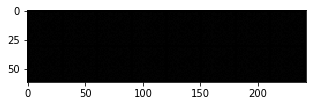

In [28]:
noise.resize_(16, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)
fake = netG(noisev)
fake = fake.mul(0.5).add(0.5)
fake = fake - fake.min()
import matplotlib.pyplot as plt
from torchvision import utils
def imshow(inp, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp,cmap='gray')
    plt.show()
dd = utils.make_grid(fake.data)
imshow(dd)
